# Experiments with $\beta$-Variational AutoEncoder with $\beta$ =1.5

## Setup

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import pandas as pd
from IPython.display import display

from torchvision.utils import make_grid
from torchvision.transforms.transforms import ToPILImage, ToTensor

from google.colab import drive
import os
import pickle

import numpy as np
import copy
import sys
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tnrange

 ## Training and evaluation functions

 ## Training and evaluation functions VAE

In [ ]:
def train_VAE_model(model, train_loader,val_loader, test_loader, VAE_criterion,eval_criterions, optimizer, device, epochs, VAE_likelihood, beta, L, fold):
    outputs = []

    average_recons_losses = []  # List to store average reconstruction losses
    average_kld_losses = []     # List to store average KLD losses
    average_vae_losses = []         # List to store average total losses
    average_vae_val_losses = []
    average_recons_val_losses = []
    average_kld_val_losses = []
    average_val_losses = []

    for epoch in range(epochs):
        model.train()
        total_vae_loss = 0.0
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        for images, _ in train_loader:
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out  = model(x_in, L)
            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)
            optimizer.zero_grad()
            vae_loss.backward()
            optimizer.step()
            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

        average_recons_loss = total_recons_loss / len(train_loader)
        average_kld_loss = total_kld_loss / len(train_loader)
        average_vae_loss = total_vae_loss / len(train_loader)

        average_recons_losses.append(average_recons_loss)
        average_kld_losses.append(average_kld_loss)
        average_vae_losses.append(average_vae_loss)


        print(f'Train Fold/Epoch: {fold + 1}/{epoch + 1}, Training Loss:{average_vae_loss:.6f}, Training Recons Loss: {average_recons_loss:.6f}, Training KLD Loss: {average_kld_loss:.6f}')


        # Validation phase

        average_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss = eval_VAE_model(fold, model, val_loader, eval_criterions, VAE_likelihood, beta, L, device)
        average_loss_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in average_loss.items()}
        average_vae_val_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in average_vae_val_loss.items()}
        average_recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in average_recons_val_loss.items()}
        average_kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in average_kld_val_loss.items()}


        average_val_losses.append(average_loss_0)
        average_vae_val_losses.append(average_vae_val_losses_1)
        average_recons_val_losses.append(average_recons_val_losses_2)
        average_kld_val_losses.append(average_kld_val_losses_3)

        print(f'Validation Fold/Epoch: {fold + 1}/{epoch + 1},  Validation Loss: {average_loss_0}, Validation VAE Loss: {average_vae_val_losses_1}, Validation Recons Loss: {average_recons_val_losses_2}, Validation KLD Loss: {average_kld_val_losses_3}')



        outputs.append((epoch, x_in, x_out))


    return outputs, average_vae_losses, average_recons_losses, average_kld_losses, average_val_losses, average_vae_val_losses, average_recons_val_losses, average_kld_val_losses

### Visualize reconstructions function VAE

In [ ]:
def VAE_visualize_original_images(test_loader, img_shape, num_samples=10, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.view(-1, img_shape[0] * img_shape[1])
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    plt.suptitle('Visualizing Original Images', fontsize=12)

    for i in range(num_samples):
        ax = plt.subplot(2, num_samples, i + 1)
        # Check if there is only one image in the batch
        if len(batch_features) == 1:
            plt.imshow(batch_features[0].numpy().reshape(img_shape))
        else:
            plt.imshow(batch_features[i].numpy().reshape(img_shape))
        plt.axis('off')

    plt.show()
def VAE_visualize_reconstructions(model, test_loader, img_shape, L, device, num_samples=10, fold_index=None, figure_size=(8, 2)):
    with torch.no_grad():
        for batch_features, _ in test_loader:
            batch_features = batch_features.to(device)
            x_in = batch_features.view(batch_features.size(0), -1)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            break

    plt.figure(figsize=figure_size)
    plt.gray()

    for i, (item_in, item_out) in enumerate(zip(x_in.cpu().numpy(), x_out.cpu().numpy())):
        if i >= num_samples:
            break
        # Plot original image
        if fold_index == 0:
          plt.subplot(2, num_samples, i + 1)
          item_in = item_in.reshape(img_shape)
          plt.imshow(item_in)
          plt.axis('off')

        # Plot reconstructed image for all folds
        plt.subplot(2, num_samples, num_samples + i + 1)
        item_out = item_out.reshape(img_shape)
        plt.imshow(item_out)
        plt.axis('off')

    plt.show()
img_shape = (28, 28)

### Evaluation functions VAE

In [ ]:
def eval_VAE_model(fold, model, test_loader, criterions, VAE_likelihood, beta, L, device):
    model.eval()
    criterion_names = list(criterions.keys())

    average_vae_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_recons_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}
    average_kld_val_loss = {criterion_name: 0.0 for criterion_name in criterion_names}

    average_total_loss = {criterion_name: 0.0 for criterion_name in criterion_names}


    for name, criterion in criterions.items():
        total_recons_loss = 0.0
        total_kld_loss = 0.0
        total_vae_loss = 0.0

        total_loss = 0.0

        for (images, _) in test_loader:
            #x_in = Variable(images.view(images.size(0), -1))
            x_in = images.view(images.size(0), -1).to(device)
            z_mu, z_logvar, z_samples, x_out = model(x_in, L)
            x_out_flat = x_out.view(x_in.size()).to(device)

            loss = criterion(x_out_flat , x_in)

            recons_loss, kld_loss, vae_loss = VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta)

            total_recons_loss += recons_loss.item()
            total_kld_loss += kld_loss.item()
            total_vae_loss += vae_loss.item()

            total_loss += loss.item()

        # Calculate the average loss for this criterion
        average_recons_loss = total_recons_loss / len(test_loader)
        average_kld_loss = total_kld_loss / len(test_loader)
        average_vae_loss = total_vae_loss / len(test_loader)

        average_loss = total_loss / len(test_loader)

        # Update the dictionaries with the average values
        average_vae_val_loss[name] = average_vae_loss
        average_recons_val_loss[name] = average_recons_loss
        average_kld_val_loss[name] = average_kld_loss

        average_total_loss[name] = average_loss

    return average_total_loss, average_vae_val_loss, average_recons_val_loss, average_kld_val_loss


## Model definitions: Pytorch Classes

## Variational Autoencoder

Code Regis Djaha

In [ ]:
# Encoder class used in VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Encoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Encoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes

        encoder_layers = []
        for i in range(1, len(encoder_hidden_sizes) - 1):
            # Remove activation at the last layer of the encoder
            if i == len(encoder_hidden_sizes) - 2:
                self.fc_mean = nn.Linear(encoder_hidden_sizes[i], D_z)
                self.fc_logvar = nn.Linear(encoder_hidden_sizes[i], D_z)
            else:
                encoder_layers.extend([nn.Linear(encoder_hidden_sizes[i], encoder_hidden_sizes[i + 1]), activation()])
        #encoder_layers.pop()
        self.encoder = nn.Sequential(*encoder_layers)

    def forward(self, x_in):
        encoded = self.encoder(x_in)
        z_mean = self.fc_mean(encoded)
        z_logvar = self.fc_logvar(encoded)

        return z_mean,z_logvar


In [ ]:
# Decoder of the VAE below
# Note the forward pass, where we compute the mean and logvariance of the latent variable
class Decoder(nn.Module):
    def __init__(self, D_x, D_z, n_layers, activation):
        super(Decoder, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        hidden_sizes = [D_x - (D_x - D_z) * i // n_layers for i in range(n_layers)] + [D_z]
        encoder_hidden_sizes = [D_x] + hidden_sizes
        decoder_hidden_sizes = encoder_hidden_sizes[::-1]

        decoder_layers = []
        for i in range(0, len(decoder_hidden_sizes) - 2):
            if i == len(decoder_hidden_sizes) - 3:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), nn.Sigmoid()])
            else:
                decoder_layers.extend([nn.Linear(decoder_hidden_sizes[i], decoder_hidden_sizes[i + 1]), activation()])

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, z):
      x_out = self.decoder(z)
      return x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))


In [ ]:
# Full VAE model, based on encoder/decoder above
class VAE(nn.Module):
    def __init__(self, D_x=784, n_layers=1, D_z=2, activation=nn.ReLU):
        super(VAE, self).__init__()
        self.D_x = D_x
        self.D_z = D_z
        self.n_layers=n_layers

        encoder = Encoder(D_x, D_z, n_layers, activation)
        decoder = Decoder(D_x, D_z, n_layers, activation)

        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x_in):
        return self.encoder(x_in)

    def decode(self, z):
        return self.decoder(z)

    def reparameterization(self, mean, logvar):
        sd = torch.exp(logvar * 0.5)
        epsilon = torch.randn_like(sd)
        z = epsilon.mul(sd).add_(mean)
        return z

    def forward(self, x_in, L=1):
        z_mean, z_logvar = self.encode(x_in)
        z_samples = []
        for _ in range(L):
            z = self.reparameterization(z_mean, z_logvar)
            z_samples.append(z)
        z_samples = torch.cat(z_samples, dim=0)
        x_out = self.decode(z_samples)
        x_out = x_out.view(-1, 1, int(self.D_x**0.5), int(self.D_x**0.5))
        return z_mean, z_logvar, z_samples, x_out

### VAE_criterion

In [ ]:
# VAE Criterion, as combination of reconstruction loss and KL divergence
# Note that the reconstruction loss can be based on the Gaussian or Bernoulli likelihood
# Note that the KL divergence term can be weighted by the input $\beta$ parameter
def VAE_criterion(x_out, x_in, z_mu, z_logvar, L, VAE_likelihood, beta=1.0):
    recons_losses = []  # Store individual reconstruction losses

    if VAE_likelihood == "gaussian":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the mean squared error (MSE) loss for each sample
            recons_loss = F.mse_loss(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)
    elif VAE_likelihood == "bernoulli":
        for i in range(L):
            # Flatten x_in to match the shape of x_out
            x_in_flat = x_in.view(x_out[i::L].shape)
            # Calculate the binary cross-entropy loss for each sample
            recons_loss = F.binary_cross_entropy(x_out[i::L], x_in_flat, reduction='sum')
            recons_losses.append(recons_loss)

    # Calculate the mean loss over the L samples
    recons_loss = (1 / L) * sum(recons_losses)/ x_out.size(0)

    kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())/ x_out.size(0)

    loss = (recons_loss + beta * kld_loss)

    return recons_loss, kld_loss, loss


### latent space VAE model

In [ ]:
def latent_space_VAE_model(model, test_loader, device, number_fold):
    model.eval()
    latent_variables = []
    labels = []

    for images, _ in test_loader:
        x_in = images.view(images.size(0), -1).to(device)
        with torch.no_grad():
            z_mean, z_logvar = model.encode(x_in)
            z = model.reparameterization(z_mean, z_logvar)
        latent_variables.append(z.cpu().numpy())
        labels.append(_.numpy())

    latent_variables = np.concatenate(latent_variables)
    labels = np.concatenate(labels)

    colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))
    colors = colormap(labels)

    # Scatter plot for latente space on the left
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    scatter_latent_variables = ax1.scatter(latent_variables[:, 0], latent_variables[:, 1], c=labels, cmap=colormap)
    ax1.set_xlabel("Latent Space 1")
    ax1.set_ylabel("Latent Space 2")
    ax1.set_title(f'Latent Space (z_size = {model.D_z}) for fold {number_fold}')
    cbar_mean = plt.colorbar(scatter_latent_variables)

    # Plot the distribution of the first latent variable (z[0]) on the right
    ax2.hist(latent_variables[:, 0], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 1')
    ax3.hist(latent_variables[:, 1], bins=50, density=True, alpha=0.5, color='blue', label='Latent Space 2')

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    x = np.linspace(-5, 5, 1000)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)
    ax2.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax2.set_xlabel("Latent Space")
    ax2.set_ylabel("Density")
    ax2.set_title(f'Distribution of Latent Space 1 (z_size = {model.D_z}) for fold {number_fold}')
    ax2.legend()

    # Overlay the standard normal distribution (mean=0, std=1) using an orange line
    ax3.plot(x, y, color='orange', label='Standard Normal Distribution')

    ax3.set_xlabel("Latent Space")
    ax3.set_ylabel("Density")
    ax3.set_title(f'Distribution of Latent Space 2 (z_size = {model.D_z}) for fold {number_fold}')
    ax3.legend()


    plt.tight_layout()
    plt.show()




### Sample new data using the decoder.

In [ ]:
def sample(model, D_z, image_to_sample=100, nrow=10):
    with torch.no_grad():
        z = torch.randn((image_to_sample, D_z)).to(device)
        samples = model.decoder(z).cpu().view(image_to_sample, 1, 28, 28)
        grid = make_grid(samples, nrow=nrow)

        # Convert image to RGBA format and set background to white
        image = ToPILImage()(grid)
        image = image.convert("RGBA")
        datas = image.getdata()
        new_data = []
        for item in datas:
            # Set non-white pixels to white
            if item[0] < 100 and item[1] < 100 and item[2] < 100:
                new_data.append((255, 255, 255, 0))
            else:
                new_data.append(item)
        image.putdata(new_data)
        image = image.convert("RGB")

        return image

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

In [ ]:
def VAE_visualize_latent_space(model, device):
    z1_range = np.linspace(-2, 2, 21)
    z2_range = np.linspace(-2, 2, 21)
    results = []

    with torch.no_grad():
        for z1 in z1_range:
            for z2 in z2_range:
                results.append(model.decoder(torch.tensor([[z1, z2]], device=device, dtype=torch.float32)).view(-1, 1, 28, 28))

    image = ToPILImage()(make_grid(torch.cat(results, dim=0), 21))

    # Convert image to RGBA format and set background to white
    image = image.convert("RGBA")
    datas = image.getdata()
    new_data = []
    for item in datas:
        # Set non-white pixels to white
        if item[0] < 100 and item[1] < 100 and item[2] < 100:
            new_data.append((255, 255, 255, 50))
        else:
            new_data.append(item)
    image.putdata(new_data)
    image = image.convert("RGB")

    plt.imshow(image)
    plt.xticks([2 + (28/2) + (28+2) * ii for ii in range(len(z2_range))], [f'{x:.1f}' for x in z2_range])
    plt.yticks([2 + (28/2) + (28+2) * ii for ii in range(len(z1_range))], [f'{x:.1f}' for x in z1_range])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(r'$z_2$')
    plt.ylabel(r'$z_1$')
    plt.show()

### VAE k_fold_cross_validation

In [ ]:
def VAE_k_fold_cross_validation(model_class, model_config, train_dataset, test_dataset, VAE_criterion, learning_rate, training_setup, beta,  L, k_folds, batch_size,
                            eval_criterions={
        'MSE': torch.nn.MSELoss(),
        'L1 Loss': torch.nn.L1Loss(),
        'BCE': torch.nn.BCELoss()
    }):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Initialize a list to store models and losses
    models = []
    fold_results = []

    # Perform k-fold cross-validation
    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Split dataset into training and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_indices)
        val_subset = torch.utils.data.Subset(train_dataset, val_indices)

        # Create data loaders
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        print(len(train_loader_fold.dataset))
        val_loader_fold = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        print(len(val_loader_fold.dataset))
        test_loader_fold = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(test_loader_fold.dataset)

        # Initialize autoencoder model

        model = model_class(**model_config).to(training_setup['device'])

        # Define loss function and optimizer after initializing the model
        criterion = VAE_criterion
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Initialize test_losses_fold
        test_losses_fold_1 = []
        test_vae_losses_fold_1 = []
        test_recons_losses_fold_1 = []
        test_kld_losses_fold_1 = []
        val_losses_fold_1 = []
        val_vae_losses_fold_1 = []
        val_recons_losses_fold_1 = []
        val_kld_losses_fold_1 = []

        # Train the model for k-fold cross-validation
        train_outputs_fold, train_vae_losses_fold, train_recons_losses_fold, train_kld_losses_fold, val_losses_fold, val_vae_losses_fold, val_recons_losses_fold, val_kld_losses_fold = train_VAE_model(
            model,
            train_loader_fold,
            val_loader_fold,
            test_loader_fold,
            criterion,
            eval_criterions,
            optimizer,
            training_setup['device'],
            training_setup['epochs'],
            training_setup['VAE_likelihood'],
            beta,
            L,
            fold
        )
        # Test and validate the model for k-fold cross-validation
        val_losses_fold_1, val_vae_losses_fold_1, val_recons_losses_fold_1, val_kld_losses_fold_1 = eval_VAE_model(fold,
                                           model,
                                           val_loader_fold,
                                           eval_criterions,
                                           training_setup['VAE_likelihood'],
                                           beta,
                                           L,
                                           training_setup['device'])
        val_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in val_losses_fold_1.items()}
        val_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in val_vae_losses_fold_1.items()}
        recons_val_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in val_recons_losses_fold_1.items()}
        kld_val_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in val_kld_losses_fold_1.items()}
        print(f'Validation results for fold {fold +1}, Validation Loss: {val_losses_0}, Validation Average VAE Loss: {val_vae_losses_1}, Validation Average Recons Loss: {recons_val_losses_2}, Validation Average KLD Loss: {kld_val_losses_3}')

        test_losses_fold_1, test_vae_losses_fold_1, test_recons_losses_fold_1, test_kld_losses_fold_1 = eval_VAE_model(fold,
                                                                                   model,
                                                                                   test_loader_fold,
                                                                                   eval_criterions,
                                                                                   training_setup['VAE_likelihood'],
                                                                                   beta,
                                                                                   L,
                                                                                   training_setup['device'])
        test_losses_0 = {criterion_name_0: loss_value_0 for criterion_name_0, loss_value_0 in test_losses_fold_1.items()}
        test_vae_losses_1 = {criterion_name_1: loss_value_1 for criterion_name_1, loss_value_1 in test_vae_losses_fold_1.items()}
        recons_test_losses_2 = {criterion_name_2: loss_value_2 for criterion_name_2, loss_value_2 in test_recons_losses_fold_1.items()}
        kld_test_losses_3 = {criterion_name_3: loss_value_3 for criterion_name_3, loss_value_3 in test_kld_losses_fold_1.items()}
        print(f'Test results for fold {fold +1}, Testing Loss: {test_losses_0}, Testing Average VAE Loss: {test_vae_losses_1}, Testing Average Recons Loss: {recons_test_losses_2}, Testing Average KLD Loss: {kld_test_losses_3}')


        # Save the model from this fold
        models.append(model)
        fold_results.append({
            "outputs": train_outputs_fold,
            "train_recons_losses_fold": train_recons_losses_fold,
            "train_kld_losses_fold": train_kld_losses_fold,
            "train_losses_fold": train_vae_losses_fold,
            "val_fold": val_losses_fold,
            "val_losses_fold": val_vae_losses_fold,
            "val_recons_losses_fold": val_recons_losses_fold,
            "val_kld_losses_fold": val_kld_losses_fold,
            "metrics_val_results": val_losses_0,
            "val_results": val_vae_losses_1 ,
            "val_recons_results": recons_val_losses_2,
            "val_kld_results": kld_val_losses_3,
            "metrics_test_results": test_losses_0,
            "test_results": test_vae_losses_1,
            "test_recons_results": recons_test_losses_2,
            "test_kld_results": kld_test_losses_3,
        })

    return models, fold_results


## plot mean and std VAE

In [ ]:
def VAE_plot_mean_std(data, title, ax, label, epochs, plot_std=True):
    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0)
    ax.plot(epochs, mean_data, label=label)

    if plot_std:
        ax.fill_between(
            epochs,
            mean_data - std_data,
            mean_data + std_data,
            alpha=0.3,
            label='Standard Deviation'
        )

    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis ticks to integers

def VAE_plot_results(kfold_results, loss_type='MSE'):

    # trin each epoch
    train_losses = []
    train_recons_losses = []
    train_kld_losses = []

    # valid each epoch
    val_losses = []
    val_recons_losses = []
    val_kld_losses = []

    # valid result
    valid_result = []
    recons_valid_result = []
    kld_valid_result = []

    # test result
    test_result = []
    recons_test_result = []
    kld_test_result = []

    # valid results metrics
    valid_metrics = []

    # test result metrics
    test_metrics = []

    epochs = None

    for fold_result in kfold_results:
        train_losses.append(fold_result['train_losses_fold'])
        train_recons_losses.append(fold_result['train_recons_losses_fold'])
        train_kld_losses.append(fold_result['train_kld_losses_fold'])


        if isinstance(fold_result['val_losses_fold'], list):
            val_losses.append([val[loss_type] for val in fold_result['val_losses_fold']])
        else:
            val_losses.append(fold_result['val_losses_fold'][loss_type])

        if isinstance(fold_result['val_recons_losses_fold'], list):
            val_recons_losses.append([val[loss_type] for val in fold_result['val_recons_losses_fold']])
        else:
            val_recons_losses.append(fold_result['val_recons_losses_fold'][loss_type])

        if isinstance(fold_result['val_kld_losses_fold'], list):
            val_kld_losses.append([val[loss_type] for val in fold_result['val_kld_losses_fold']])
        else:
            val_kld_losses.append(fold_result['val_kld_losses_fold'][loss_type])

            # valid result

        if isinstance(fold_result['val_results'], list):
            valid_result.append([val[loss_type] for val in fold_result['val_results']])
        else:
            valid_result.append(fold_result['val_results'][loss_type])

        if isinstance(fold_result['val_recons_results'], list):
            recons_valid_result.append([val[loss_type] for val in fold_result['val_recons_results']])
        else:
            recons_valid_result.append(fold_result['val_recons_results'][loss_type])

        if isinstance(fold_result['val_kld_results'], list):
            kld_valid_result.append([val[loss_type] for val in fold_result['val_kld_results']])
        else:
            kld_valid_result.append(fold_result['val_kld_results'][loss_type])

        # test result
        if isinstance(fold_result['test_results'], list):
            test_result.append([val[loss_type] for val in fold_result['test_results']])
        else:
            test_result.append(fold_result['test_results'][loss_type])

        if isinstance(fold_result['test_recons_results'], list):
            recons_test_result.append([val[loss_type] for val in fold_result['test_recons_results']])
        else:
            recons_test_result.append(fold_result['test_recons_results'][loss_type])

        if isinstance(fold_result['test_kld_results'], list):
            kld_test_result.append([val[loss_type] for val in fold_result['test_kld_results']])
        else:
            kld_test_result.append(fold_result['test_kld_results'][loss_type])

            # valid results metrics

         # valid result
        if isinstance(fold_result['metrics_val_results'], list):
            valid_metrics.append([val[loss_type] for val in fold_result['metrics_val_results']])
        else:
            valid_metrics.append(fold_result['metrics_val_results'][loss_type])

        # test result
        if isinstance(fold_result['metrics_test_results'], list):
            test_metrics.append([val[loss_type] for val in fold_result['metrics_test_results']])
        else:
            test_metrics.append(fold_result['metrics_test_results'][loss_type])

        if epochs is None:
            epochs = np.arange(1, len(train_recons_losses[0]) + 1)

    # Convert lists to numpy arrays
    train_losses = np.array(train_losses)
    train_recons_losses = np.array(train_recons_losses)
    train_kld_losses = np.array(train_kld_losses)


    val_losses = np.array(val_losses)
    val_recons_losses = np.array(val_recons_losses)
    val_kld_losses = np.array(val_kld_losses)

    valid_result = np.array(valid_result)
    recons_valid_result = np.array(recons_valid_result)
    kld_valid_result = np.array(kld_valid_result)

    test_result = np.array(test_result)
    recons_test_result = np.array(recons_test_result)
    kld_test_result = np.array(kld_test_result)

    valid_metrics = np.array(valid_metrics)
    test_metrics = np.array(test_metrics)

     # Calculate mean for validation
    mean_valid_metrics = np.mean(valid_metrics)
    std_valid_metrics = np.std(valid_metrics)

    mean_valid_result = np.mean(valid_result)
    std_valid_result = np.std(valid_result)

    mean_recons_valid_result = np.mean(recons_valid_result)
    std_recons_valid_result = np.std(recons_valid_result)

    mean_kld_valid_result = np.mean(kld_valid_result)
    std_kld_valid_result = np.std(kld_valid_result)

    # Calculate mean for testing
    mean_test_metrics = np.mean(test_metrics)
    std_test_metrics = np.std(test_metrics)

    mean_test_result = np.mean(test_result)
    std_test_result = np.std(test_result)

    mean_recons_test_result = np.mean(recons_test_result)
    std_recons_test_result = np.std(recons_test_result)

    mean_kld_test_result = np.mean(kld_test_result)
    std_kld_test_result = np.std(kld_test_result)

    return {
        'mean_valid_metrics': mean_valid_metrics,
        'std_valid_metrics': std_valid_metrics,
        'mean_valid_result': mean_valid_result,
        'std_valid_result': std_valid_result,
        'mean_recons_valid_result': mean_recons_valid_result,
        'std_recons_valid_result': std_recons_valid_result,
        'mean_kld_valid_result': mean_kld_valid_result,
        'std_kld_valid_result': std_kld_valid_result,
        'mean_test_metrics ': mean_test_metrics ,
        'std_test_metrics': std_test_metrics,
        'mean_test_result': mean_test_result,
        'std_test_result': std_test_result,
        'mean_recons_test_result': mean_recons_test_result,
        'std_recons_test_result': std_recons_test_result,
        'mean_kld_test_result': mean_kld_test_result,
        'std_kld_test_result': std_kld_test_result,
        'epochs': epochs,
        'train_losses': train_losses,
        'train_recons_losses':train_recons_losses,
        'train_kld_losses': train_kld_losses,
        'val_losses': val_losses,
        'val_recons_losses': val_recons_losses,
        'val_kld_losses': val_kld_losses,
        'valid_result': valid_result,
        'recons_valid_result': recons_valid_result,
        'kld_valid_result': kld_valid_result,
        'test_result': test_result,
        'recons_test_result': recons_test_result,
        'kld_test_result': kld_test_result,
        'valid_metrics': valid_metrics,
        'test_metrics': test_metrics,
    }
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

def print_evaluation_table(valid_metrics, test_metrics, valid_result, test_result, recons_valid_result, recons_test_result,kld_valid_result, kld_test_result):
    # Calculate mean and standard deviation for Validation Loss and Test Loss
    mean_valid_metrics_loss = np.mean(valid_metrics)
    std_valid_metrics_loss = np.std(valid_metrics)
    mean_valid_loss = np.mean(valid_result)
    std_valid_loss = np.std(valid_result)
    mean_recons_valid_result_loss = np.mean(recons_valid_result)
    std_recons_valid_result_loss = np.std(recons_valid_result)
    mean_kld_valid_result_loss = np.mean(kld_valid_result)
    std_kld_valid_result_loss = np.std(kld_valid_result)

    mean_test_metrics_loss = np.mean(test_metrics)
    std_test_metrics_loss = np.std(test_metrics)
    mean_test_loss = np.mean(test_result)
    std_test_loss = np.std(test_result)
    mean_recons_test_result_loss = np.mean(recons_valid_result)
    std_recons_test_result_loss = np.std(recons_valid_result)
    mean_kld_test_result_loss = np.mean(kld_test_result)
    std_kld_test_result_loss = np.std(kld_test_result)

    # Create a DataFrame for mean and standard deviation
    evaluation_summary_dict = {
    'Metric': ['Mean', 'Standard Deviation'],
    'Validation Metrics Loss': [mean_valid_metrics_loss, std_valid_metrics_loss],
    'Test Metrics Loss': [mean_test_metrics_loss, std_test_metrics_loss],
    'Validation VAE Loss': [mean_valid_loss, std_valid_loss],
    'Test VAE Loss': [mean_test_loss, std_test_loss],
    'Validation Recons Loss': [mean_recons_valid_result_loss, std_recons_valid_result_loss],
    'Test Recons Loss': [mean_recons_test_result_loss, std_recons_test_result_loss],
    'Validation KLD Loss': [mean_kld_valid_result_loss, std_kld_valid_result_loss],
    'Test KLD Loss': [mean_kld_test_result_loss, std_kld_test_result_loss]
}

    df_summary = pd.DataFrame(evaluation_summary_dict)

    # Print the mean and standard deviation table
    print("\nMean and Standard Deviation Table:")
    print(df_summary.to_string(index=False))


    # Print the detailed evaluation table with highlighted rows
    min_val_loss_index = np.argmin(valid_result)
    evaluation_dict = {
        'Fold': np.arange(1, len(valid_result) + 1),
        'Validation Metrics Loss': valid_metrics,
        'Test Metrics Loss': test_metrics,
        'Validation Loss': valid_result,
        'Test Loss': test_result
    }

    df = pd.DataFrame(evaluation_dict)


    # Display the Detailed Evaluation Table with proper styling
    styles = [
        dict(selector=f'.row{min_val_loss_index + 2}', props=[('background-color', 'lightgreen')])
    ]
    #df_styled = df.style.set_table_styles(styles, axis=1)
    df_styled = df.style.apply(highlight_min, subset=['Validation Loss'], axis=0)

    print("\nDetailed Evaluation Table:")
    display(df_styled)

## Experiments with MNIST

### Set our seed and other configurations for reproducibility.

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Dataset

#### We load our MNIST dataset using the torchvision package.

#### We need to specify the batch size for the dataloader first

In [ ]:
batch_size=64

In [ ]:
# Load MNIST Training data
# Note that we shuffle the training data
train_loader = DataLoader(
    MNIST(
      root='./data',
      train=True,
      download=True,
      transform=transforms.ToTensor()),
       batch_size=batch_size,
       shuffle=True
    )

100%|██████████| 9912422/9912422 [00:00<00:00, 88621117.88it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23944592.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31273814.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4769786.87it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Load MNIST Test data
# Note that we DO NOT shuffle the test data
test_loader = DataLoader(
    MNIST(
      root='./data',
      train=False,
      download=True,
      transform=transforms.ToTensor()),
      batch_size=batch_size,
      shuffle=False
    )

#### Total number of images in the training and testing sets

In [ ]:
print("Total number of training images:", len(train_loader.dataset))
print("Total number of testing images:", len(test_loader.dataset))

Total number of training images: 60000
Total number of testing images: 10000


In [ ]:
examples = iter(train_loader)
example_data, example_targets = next(examples)
print(example_data.shape)
print(example_targets)

torch.Size([64, 1, 28, 28])
tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4, 0, 3, 9, 9, 5, 6, 7, 8, 8, 9, 2, 6, 9, 3,
        0, 5, 0, 7, 6, 1, 2, 0, 7, 4, 6, 0, 6, 9, 7, 0, 7, 3, 2, 5, 9, 0, 4, 8,
        3, 6, 4, 0, 3, 2, 6, 6, 3, 2, 2, 3, 6, 7, 8, 4])


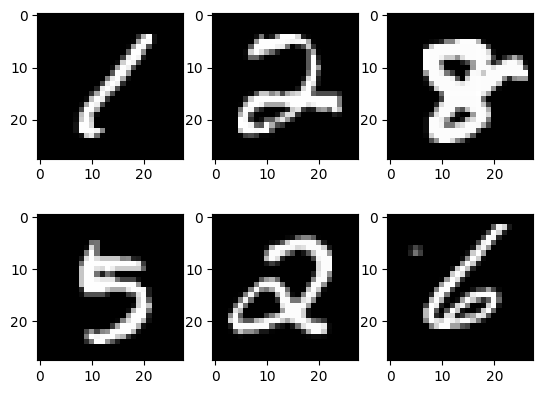

In [ ]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Experiments with MNIST: $β$-Variational Autoencoder

### Experiments 1 : VAE with $\beta$ =0.02 with n_layer=1

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32, 64}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

## Test 1: $β$-VAE: BCE

### Experiment 3.1 : VAE with 1 layer

- Model: VAE of 1 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_1 = 'VAE'
model_config_5_1 = {'D_x': 784, 'n_layers': 1, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_1, fold_results_5_1 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_1),
                                                model_config=model_config_5_1,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:325.187453, Training Recons Loss: 307.915882, Training KLD Loss: 11.514381
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.06862912517278752, 'L1 Loss': 0.16751449158851137, 'BCE': 0.27805231733525054}, Validation VAE Loss: {'MSE': 237.38999646775267, 'L1 Loss': 237.35933084690825, 'BCE': 237.51907332400057}, Validation Recons Loss: {'MSE': 217.86394062448056, 'L1 Loss': 217.83327500363615, 'BCE': 217.99301699374584}, Validation KLD Loss: {'MSE': 13.017371005200324, 'L1 Loss': 13.017371005200324, 'BCE': 13.017371005200324}
Train Fold/Epoch: 1/2, Training Loss:227.879720, Training Recons Loss: 212.314986, Training KLD Loss: 10.376490
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.06504431144988283, 'L1 Loss': 0.15674019097647768, 'BCE': 0.2637117031089803}, Validation VAE Loss: {'MSE

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_1.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_1.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_1, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_1, f)


## Visualizing reconstructions for all fold

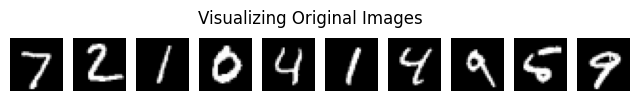

Visualizing reconstructions for fold 1


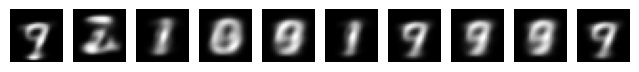

Visualizing reconstructions for fold 2


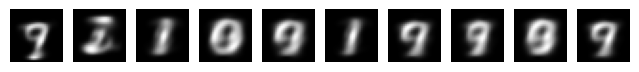

Visualizing reconstructions for fold 3


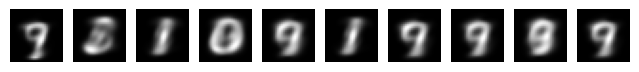

Visualizing reconstructions for fold 4


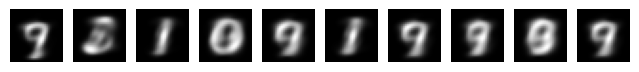

Visualizing reconstructions for fold 5


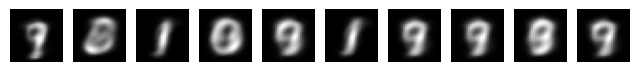

Visualizing reconstructions for fold 6


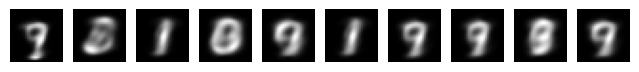

Visualizing reconstructions for fold 7


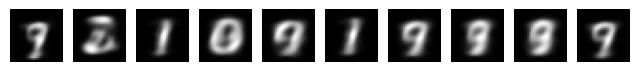

Visualizing reconstructions for fold 8


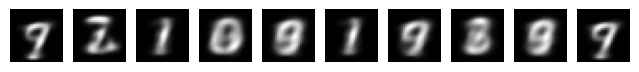

Visualizing reconstructions for fold 9


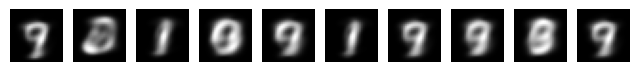

Visualizing reconstructions for fold 10


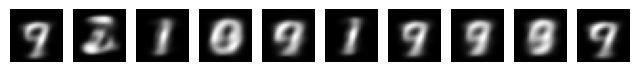

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_1.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_1 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_1):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

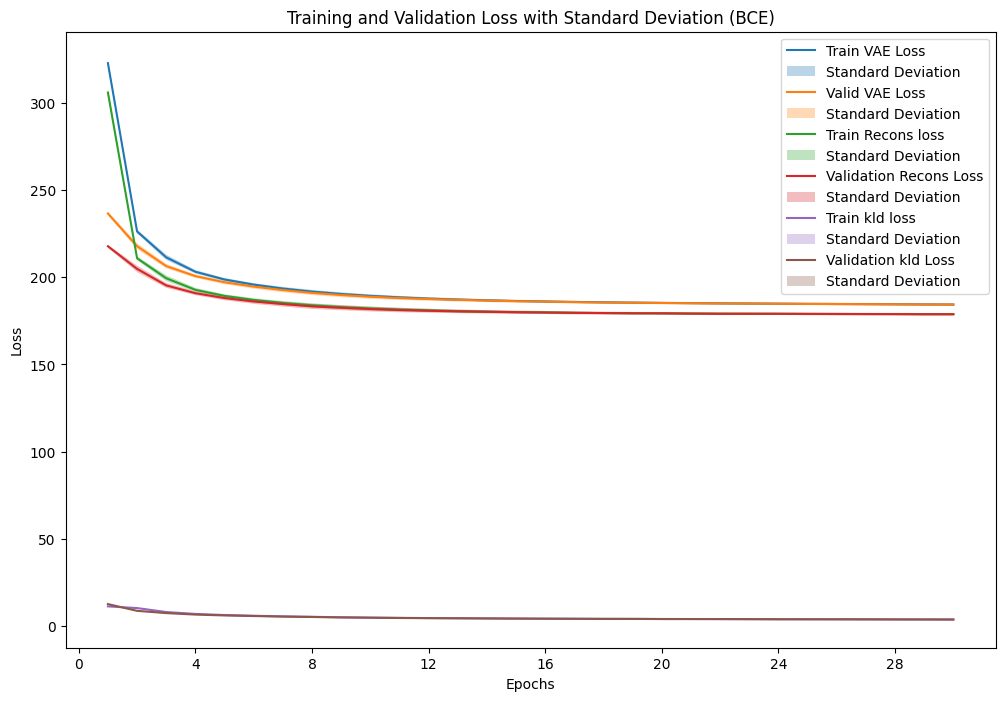

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_1 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_1_1 = VAE_plot_results(fold_results_5_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_1_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_1_1['epochs'])
    VAE_plot_mean_std(result_data_5_1_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_1_1['epochs'])
    VAE_plot_mean_std(result_data_5_1_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_1_1['epochs'])
    VAE_plot_mean_std(result_data_5_1_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_1_1['epochs'])
    VAE_plot_mean_std(result_data_5_1_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_1_1['epochs'])
    VAE_plot_mean_std(result_data_5_1_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_1_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_1_1['valid_metrics'],
    result_data_5_1_1['test_metrics'],
    result_data_5_1_1['valid_result'],
    result_data_5_1_1['test_result'],
    result_data_5_1_1['recons_valid_result'],
    result_data_5_1_1['recons_test_result'],
    result_data_5_1_1['kld_valid_result'],
    result_data_5_1_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.228052           0.226930           184.316746     183.454691              178.792735        178.792735             3.682673       3.694133
Standard Deviation                 0.000902           0.000231             0.706863       0.112864                0.706948          0.706948             0.106397       0.101990

Detailed Evaluation Table:


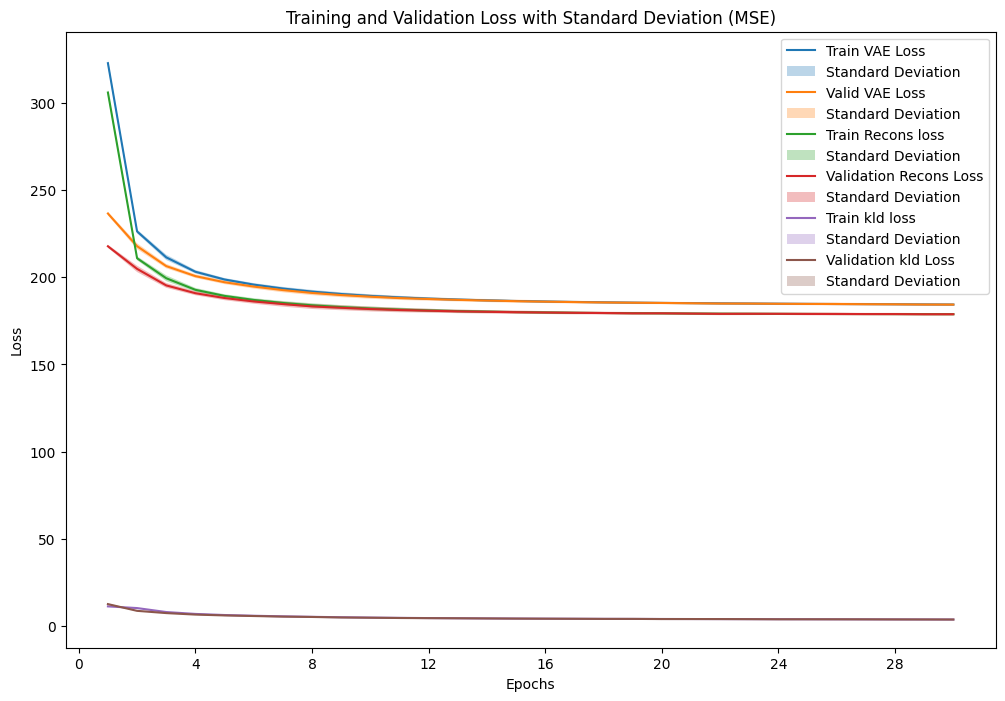

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_2 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_1_2 = VAE_plot_results(fold_results_5_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_1_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_1_2['epochs'])
    VAE_plot_mean_std(result_data_5_1_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_1_2['epochs'])
    VAE_plot_mean_std(result_data_5_1_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_1_2['epochs'])
    VAE_plot_mean_std(result_data_5_1_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_1_2['epochs'])
    VAE_plot_mean_std(result_data_5_1_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_1_2['epochs'])
    VAE_plot_mean_std(result_data_5_1_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_1_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_1_2['valid_metrics'],
    result_data_5_1_2['test_metrics'],
    result_data_5_1_2['valid_result'],
    result_data_5_1_2['test_result'],
    result_data_5_1_2['recons_valid_result'],
    result_data_5_1_2['recons_test_result'],
    result_data_5_1_2['kld_valid_result'],
    result_data_5_1_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.056202           0.055972           184.296957     183.463283              178.772947        178.772947             3.682673       3.694133
Standard Deviation                 0.000271           0.000083             0.691147       0.104943                0.695196          0.695196             0.106397       0.101990

Detailed Evaluation Table:


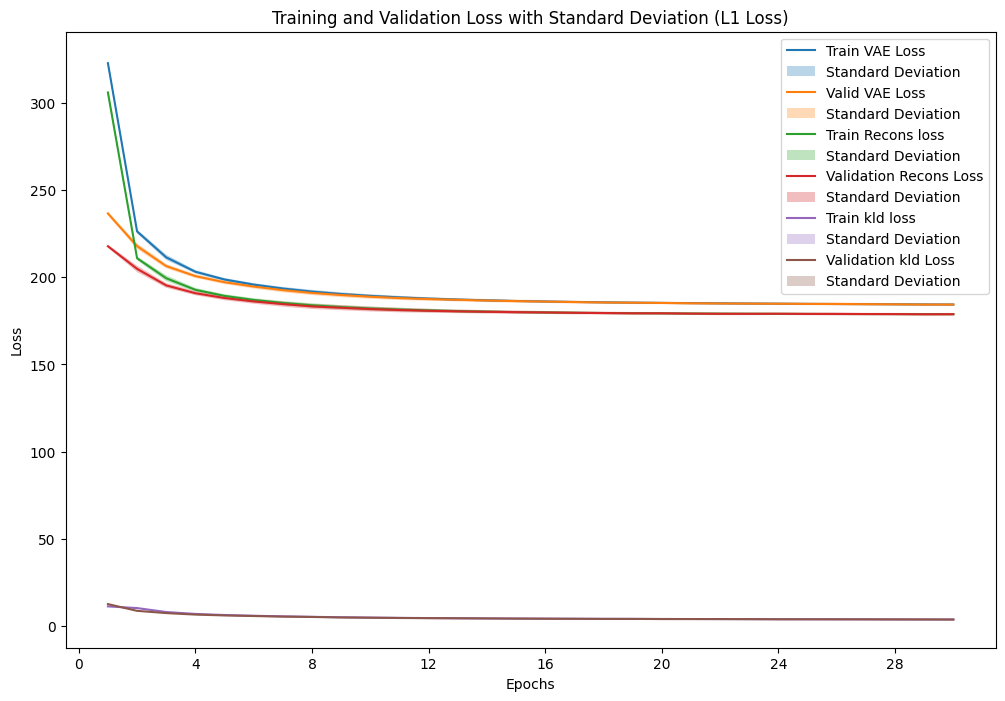

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_1.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_1 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_1_3 = VAE_plot_results(fold_results_5_1, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_1_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_1_3['epochs'])
    VAE_plot_mean_std(result_data_5_1_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_1_3['epochs'])
    VAE_plot_mean_std(result_data_5_1_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_1_3['epochs'])
    VAE_plot_mean_std(result_data_5_1_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_1_3['epochs'])
    VAE_plot_mean_std(result_data_5_1_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_1_3['epochs'])
    VAE_plot_mean_std(result_data_5_1_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_1_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_1_3['valid_metrics'],
    result_data_5_1_3['test_metrics'],
    result_data_5_1_3['valid_result'],
    result_data_5_1_3['test_result'],
    result_data_5_1_3['recons_valid_result'],
    result_data_5_1_3['recons_test_result'],
    result_data_5_1_3['kld_valid_result'],
    result_data_5_1_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.127275           0.127098           184.308211     183.464356              178.784200        178.784200             3.682673       3.694133
Standard Deviation                 0.000496           0.000498             0.703154       0.110962                0.705501          0.705501             0.106397       0.101990

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_1 = sum(p.numel() for p in models_5_1[0].parameters())
print(f"Number of parameters in the model: {total_params_5_1}")

Number of parameters in the model: 5492


### Latent Space Visualization

<ipython-input-9-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


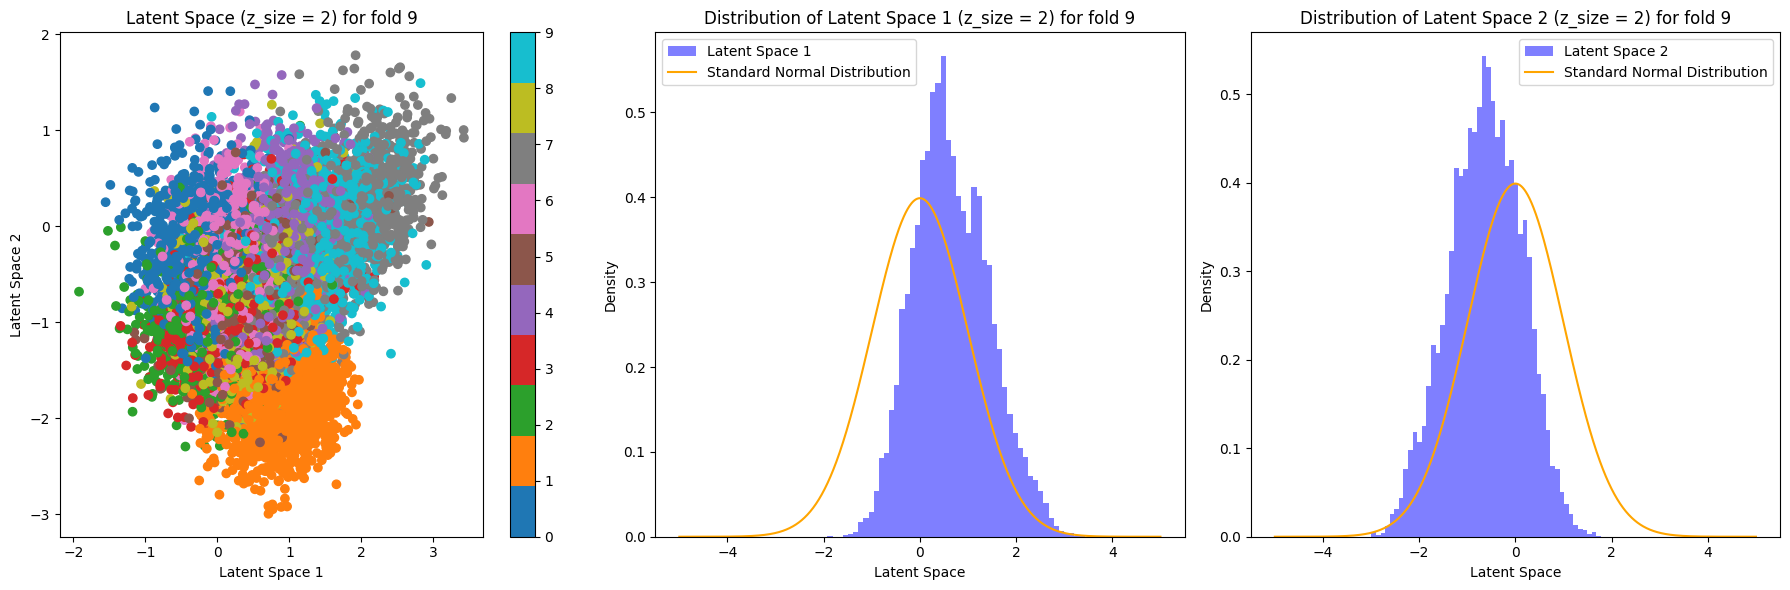

In [ ]:
latent_space_VAE_model(models_5_1[8], test_loader, device, number_fold=9)

### Sample new data using the decoder.

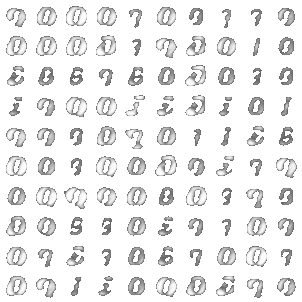

In [ ]:
sample(models_5_1[8],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

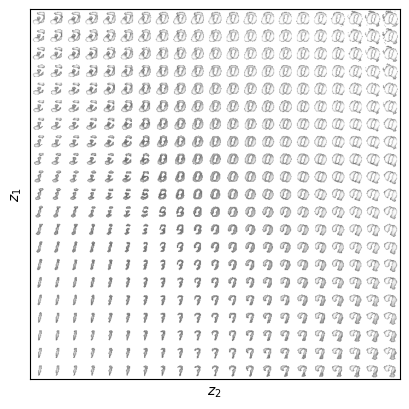

In [ ]:
VAE_visualize_latent_space(models_5_1[8], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 1 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_2 = 'VAE'
model_config_5_2 = {'D_x': 784, 'n_layers': 1, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_2, fold_results_5_2 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_2),
                                                model_config=model_config_5_2,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:243.497293, Training Recons Loss: 211.419702, Training KLD Loss: 21.385061
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.04195160838834783, 'L1 Loss': 0.11627249078864747, 'BCE': 0.20009838520212375}, Validation VAE Loss: {'MSE': 186.11153363166972, 'L1 Loss': 186.32040502669963, 'BCE': 186.03574809622256}, Validation Recons Loss: {'MSE': 156.95292046729554, 'L1 Loss': 157.1617912130153, 'BCE': 156.87713428253824}, Validation KLD Loss: {'MSE': 19.439076058408048, 'L1 Loss': 19.439076058408048, 'BCE': 19.439076058408048}
Train Fold/Epoch: 1/2, Training Loss:172.220025, Training Recons Loss: 141.552245, Training KLD Loss: 20.445186
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.0328472606599965, 'L1 Loss': 0.08907966331598606, 'BCE': 0.16759550920192232}, Validation VAE Loss: {'MSE'

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_2.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_2.pkl')

In [ ]:
# Save models_3_2
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_2, f)

# Save fold_results_3_2
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_2, f)


## Visualizing reconstructions for all fold

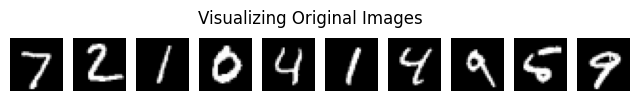

Visualizing reconstructions for fold 1


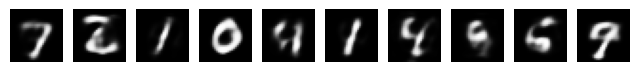

Visualizing reconstructions for fold 2


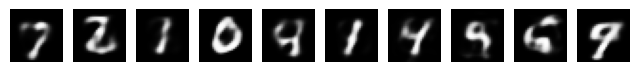

Visualizing reconstructions for fold 3


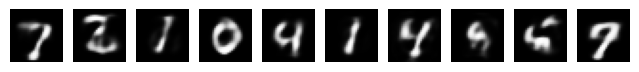

Visualizing reconstructions for fold 4


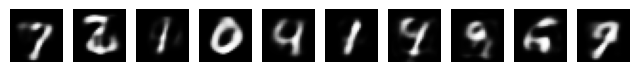

Visualizing reconstructions for fold 5


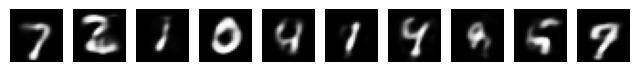

Visualizing reconstructions for fold 6


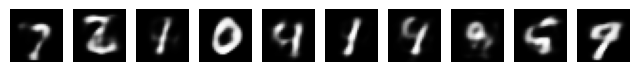

Visualizing reconstructions for fold 7


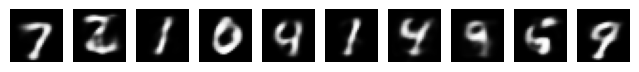

Visualizing reconstructions for fold 8


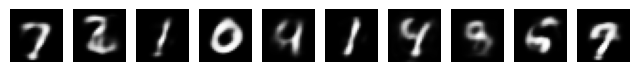

Visualizing reconstructions for fold 9


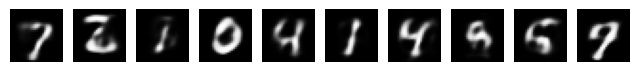

Visualizing reconstructions for fold 10


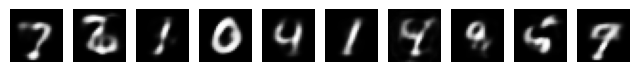

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_2.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_2 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_2):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

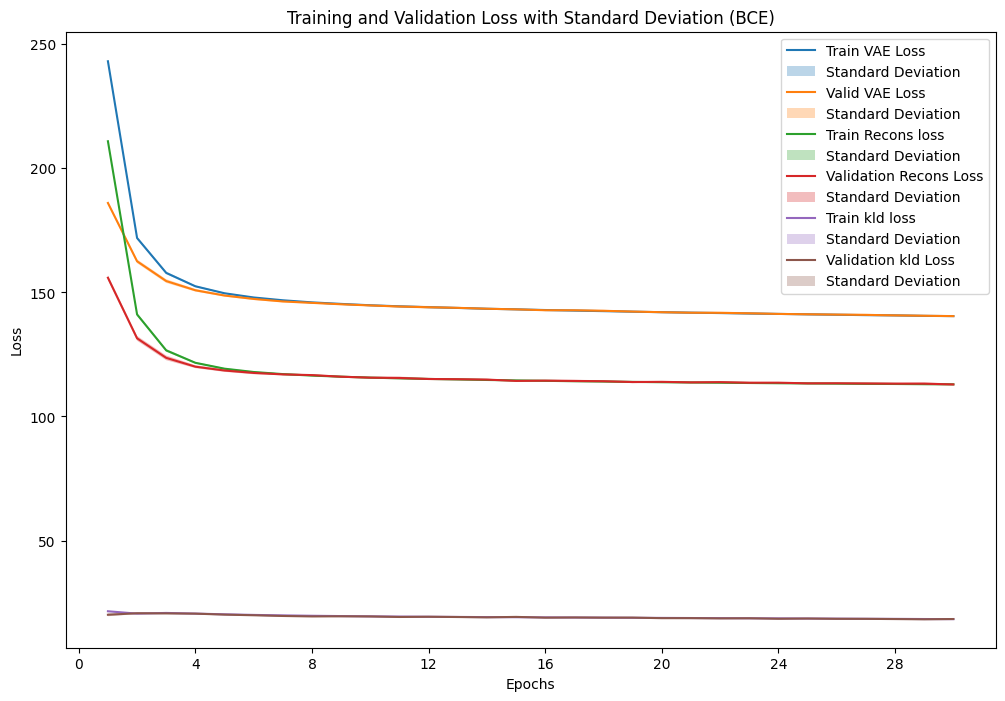

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_2 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_2_1 = VAE_plot_results(fold_results_5_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_2_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_2_1['epochs'])
    VAE_plot_mean_std(result_data_5_2_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_2_1['epochs'])
    VAE_plot_mean_std(result_data_5_2_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_2_1['epochs'])
    VAE_plot_mean_std(result_data_5_2_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_2_1['epochs'])
    VAE_plot_mean_std(result_data_5_2_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_2_1['epochs'])
    VAE_plot_mean_std(result_data_5_2_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_2_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_2_1['valid_metrics'],
    result_data_5_2_1['test_metrics'],
    result_data_5_2_1['valid_result'],
    result_data_5_2_1['test_result'],
    result_data_5_2_1['recons_valid_result'],
    result_data_5_2_1['recons_test_result'],
    result_data_5_2_1['kld_valid_result'],
    result_data_5_2_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.144052           0.142173           140.486450     139.140850              112.936380        112.936380            18.366713      18.451478
Standard Deviation                 0.000532           0.000421             0.363425       0.097008                0.416892          0.416892             0.200398       0.215534

Detailed Evaluation Table:


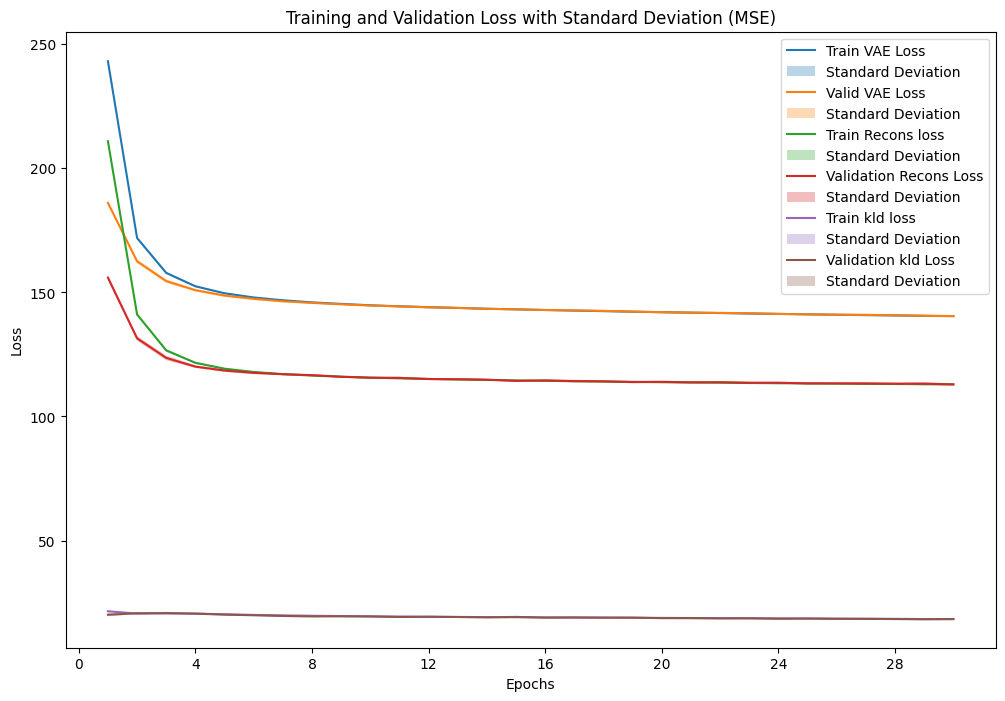

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_2 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_2_2 = VAE_plot_results(fold_results_5_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_2_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_2_2['epochs'])
    VAE_plot_mean_std(result_data_5_2_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_2_2['epochs'])
    VAE_plot_mean_std(result_data_5_2_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_2_2['epochs'])
    VAE_plot_mean_std(result_data_5_2_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_2_2['epochs'])
    VAE_plot_mean_std(result_data_5_2_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_2_2['epochs'])
    VAE_plot_mean_std(result_data_5_2_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_2_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_2_2['valid_metrics'],
    result_data_5_2_2['test_metrics'],
    result_data_5_2_2['valid_result'],
    result_data_5_2_2['test_result'],
    result_data_5_2_2['recons_valid_result'],
    result_data_5_2_2['recons_test_result'],
    result_data_5_2_2['kld_valid_result'],
    result_data_5_2_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.026644           0.026095           140.471551     139.134315              112.921481        112.921481            18.366713      18.451478
Standard Deviation                 0.000139           0.000136             0.344884       0.134329                0.341285          0.341285             0.200398       0.215534

Detailed Evaluation Table:


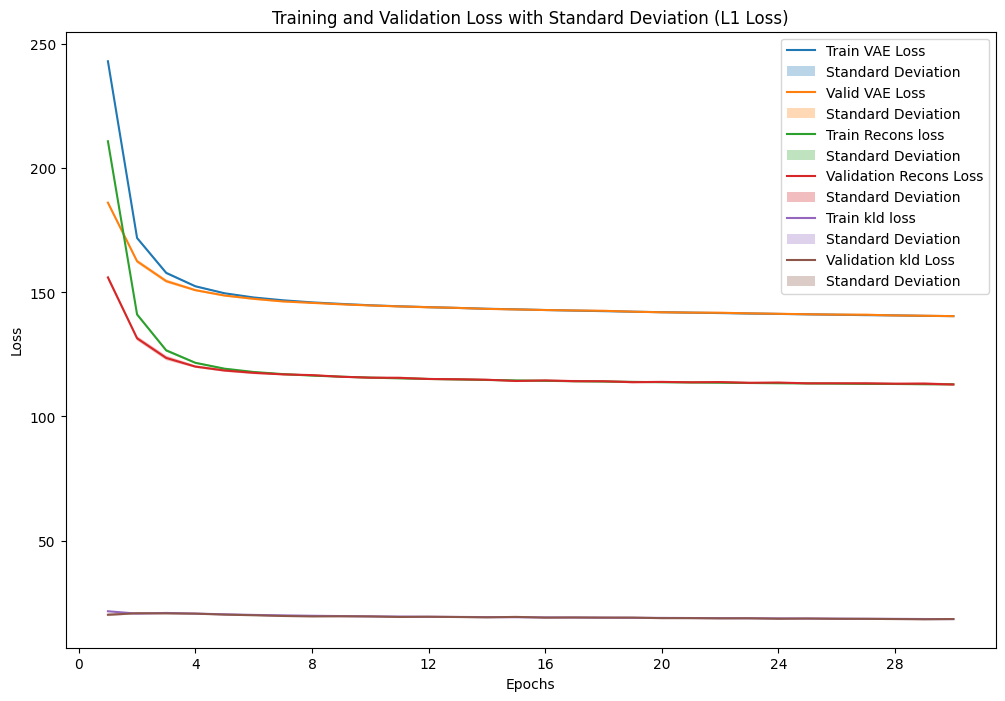

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_2.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_2 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_2_3 = VAE_plot_results(fold_results_5_2, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_2_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_2_3['epochs'])
    VAE_plot_mean_std(result_data_5_2_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_2_3['epochs'])
    VAE_plot_mean_std(result_data_5_2_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_2_3['epochs'])
    VAE_plot_mean_std(result_data_5_2_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_2_3['epochs'])
    VAE_plot_mean_std(result_data_5_2_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_2_3['epochs'])
    VAE_plot_mean_std(result_data_5_2_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_2_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_2_3['valid_metrics'],
    result_data_5_2_3['test_metrics'],
    result_data_5_2_3['valid_result'],
    result_data_5_2_3['test_result'],
    result_data_5_2_3['recons_valid_result'],
    result_data_5_2_3['recons_test_result'],
    result_data_5_2_3['kld_valid_result'],
    result_data_5_2_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.068995           0.068086           140.464529     139.127744              112.914459        112.914459            18.366713      18.451478
Standard Deviation                 0.000316           0.000331             0.400591       0.132045                0.381556          0.381556             0.200398       0.215534

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_2 = sum(p.numel() for p in models_5_2[0].parameters())
print(f"Number of parameters in the model: {total_params_5_2}")

Number of parameters in the model: 38448


### Sample new data using the decoder.

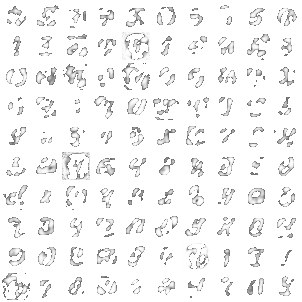

In [ ]:
sample(models_5_2[8],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_3 = 'VAE'
model_config_5_3 = {'D_x': 784, 'n_layers': 1, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_3, fold_results_5_3 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_3),
                                                model_config=model_config_5_3,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:225.862790, Training Recons Loss: 190.230692, Training KLD Loss: 23.754732
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.03640005444275572, 'L1 Loss': 0.09855257830721267, 'BCE': 0.17998203334022075}, Validation VAE Loss: {'MSE': 177.0802648016747, 'L1 Loss': 177.0518576439391, 'BCE': 177.0922905130589}, Validation Recons Loss: {'MSE': 141.09388943935963, 'L1 Loss': 141.06548163231383, 'BCE': 141.1059146637612}, Validation KLD Loss: {'MSE': 23.99091673911886, 'L1 Loss': 23.99091673911886, 'BCE': 23.99091673911886}
Train Fold/Epoch: 1/2, Training Loss:165.409734, Training Recons Loss: 128.520350, Training KLD Loss: 24.592923
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.027552022242007104, 'L1 Loss': 0.07879501073918443, 'BCE': 0.1520980621906037}, Validation VAE Loss: {'MSE': 157

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_3.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_3.pkl')

In [ ]:
# Save models_3_3
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_3, f)

# Save fold_results_3_3
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_3, f)


## Visualizing reconstructions for all fold

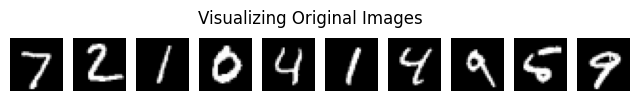

Visualizing reconstructions for fold 1


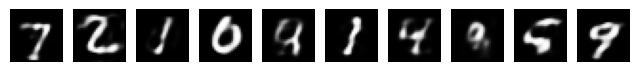

Visualizing reconstructions for fold 2


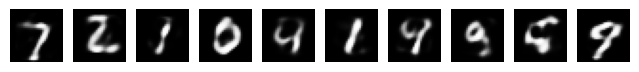

Visualizing reconstructions for fold 3


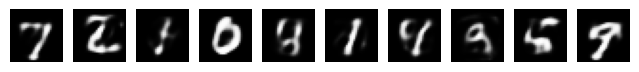

Visualizing reconstructions for fold 4


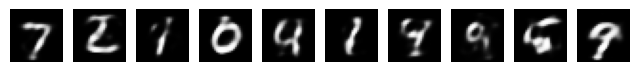

Visualizing reconstructions for fold 5


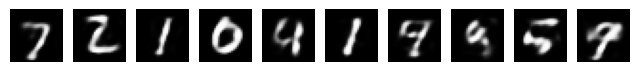

Visualizing reconstructions for fold 6


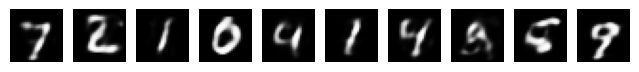

Visualizing reconstructions for fold 7


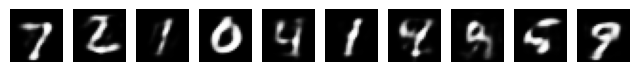

Visualizing reconstructions for fold 8


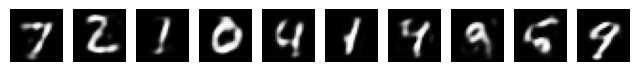

Visualizing reconstructions for fold 9


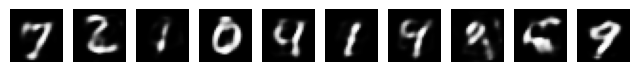

Visualizing reconstructions for fold 10


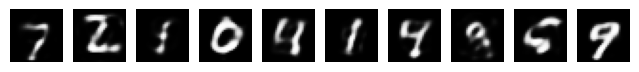

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_3.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_3 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_3):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

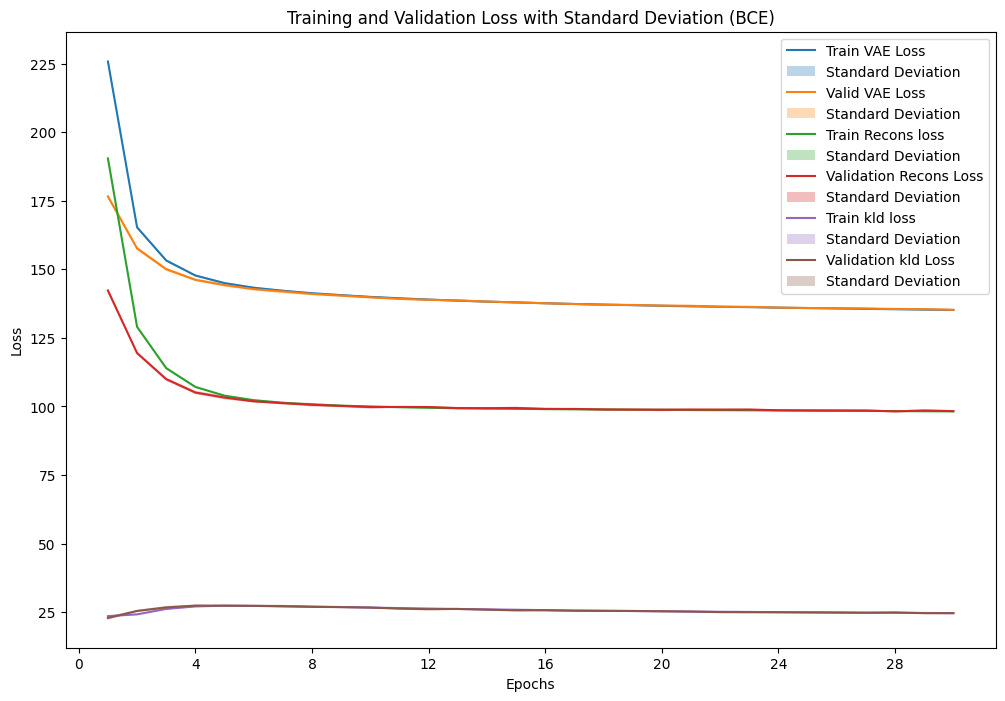

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_3 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_3_1 = VAE_plot_results(fold_results_5_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_3_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_3_1['epochs'])
    VAE_plot_mean_std(result_data_5_3_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_3_1['epochs'])
    VAE_plot_mean_std(result_data_5_3_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_3_1['epochs'])
    VAE_plot_mean_std(result_data_5_3_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_3_1['epochs'])
    VAE_plot_mean_std(result_data_5_3_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_3_1['epochs'])
    VAE_plot_mean_std(result_data_5_3_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_3_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_3_1['valid_metrics'],
    result_data_5_3_1['test_metrics'],
    result_data_5_3_1['valid_result'],
    result_data_5_3_1['test_result'],
    result_data_5_3_1['recons_valid_result'],
    result_data_5_3_1['recons_test_result'],
    result_data_5_3_1['kld_valid_result'],
    result_data_5_3_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.125470           0.123643           135.311987     133.954105               98.368770         98.368770            24.628812      24.678812
Standard Deviation                 0.000489           0.000402             0.309874       0.178324                0.383703          0.383703             0.218391       0.169420

Detailed Evaluation Table:


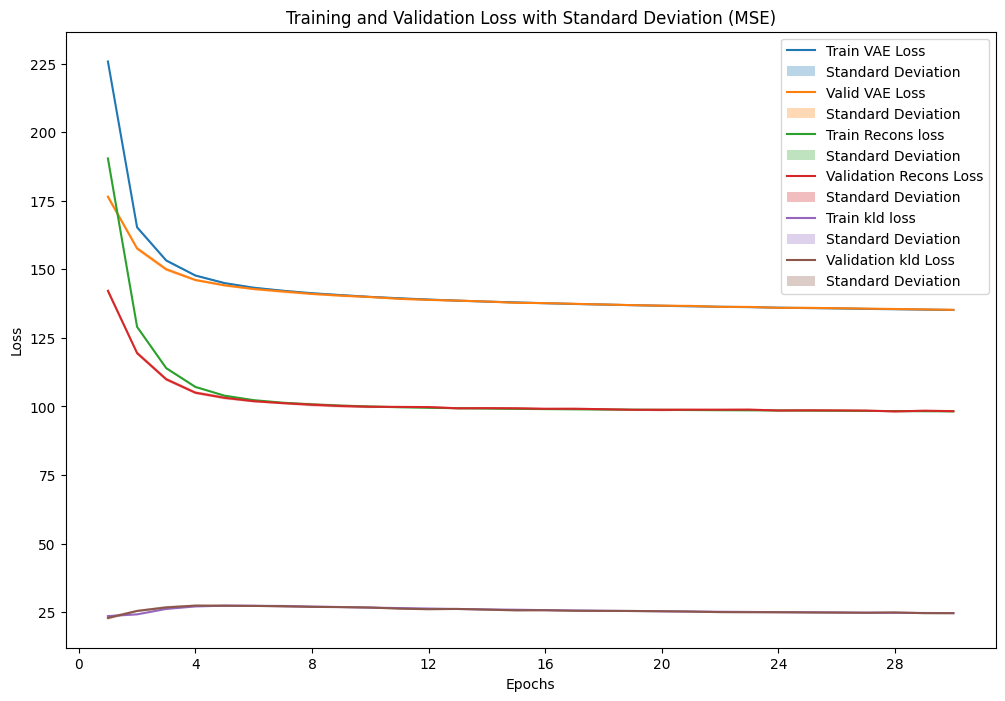

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_3 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_3_2 = VAE_plot_results(fold_results_5_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_3_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_3_2['epochs'])
    VAE_plot_mean_std(result_data_5_3_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_3_2['epochs'])
    VAE_plot_mean_std(result_data_5_3_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_3_2['epochs'])
    VAE_plot_mean_std(result_data_5_3_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_3_2['epochs'])
    VAE_plot_mean_std(result_data_5_3_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_3_2['epochs'])
    VAE_plot_mean_std(result_data_5_3_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_3_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_3_2['valid_metrics'],
    result_data_5_3_2['test_metrics'],
    result_data_5_3_2['valid_result'],
    result_data_5_3_2['test_result'],
    result_data_5_3_2['recons_valid_result'],
    result_data_5_3_2['recons_test_result'],
    result_data_5_3_2['kld_valid_result'],
    result_data_5_3_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.020393           0.019897           135.218573     133.919447               98.275356         98.275356            24.628812      24.678812
Standard Deviation                 0.000170           0.000130             0.366237       0.175713                0.471298          0.471298             0.218391       0.169420

Detailed Evaluation Table:


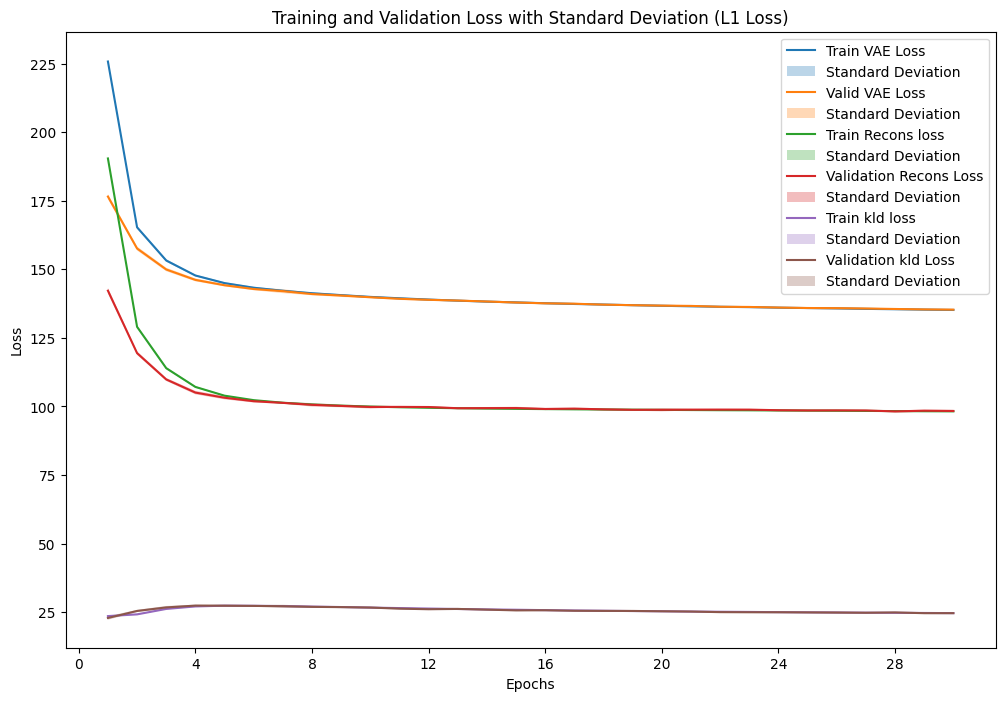

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_3.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_3 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_3_3 = VAE_plot_results(fold_results_5_3, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_3_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_3_3['epochs'])
    VAE_plot_mean_std(result_data_5_3_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_3_3['epochs'])
    VAE_plot_mean_std(result_data_5_3_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_3_3['epochs'])
    VAE_plot_mean_std(result_data_5_3_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_3_3['epochs'])
    VAE_plot_mean_std(result_data_5_3_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_3_3['epochs'])
    VAE_plot_mean_std(result_data_5_3_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_3_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_3_3['valid_metrics'],
    result_data_5_3_3['test_metrics'],
    result_data_5_3_3['valid_result'],
    result_data_5_3_3['test_result'],
    result_data_5_3_3['recons_valid_result'],
    result_data_5_3_3['recons_test_result'],
    result_data_5_3_3['kld_valid_result'],
    result_data_5_3_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.056221           0.055370           135.282559      133.97056               98.339342         98.339342            24.628812      24.678812
Standard Deviation                 0.000164           0.000197             0.370563        0.12917                0.400351          0.400351             0.218391       0.169420

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_3 = sum(p.numel() for p in models_5_3[0].parameters())
print(f"Number of parameters in the model: {total_params_5_3}")

Number of parameters in the model: 76112


### Sample new data using the decoder.

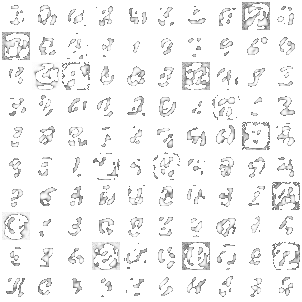

In [ ]:
sample(models_5_3[8],D_z=32)

### Experiment 3.4 : VAE with $\beta$ =0.02 with n_layer=1

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_4 = 'VAE'
model_config_5_4 = {'D_x': 784, 'n_layers': 1, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_4, fold_results_5_4 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_4),
                                                model_config=model_config_5_4,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:214.505443, Training Recons Loss: 177.522227, Training KLD Loss: 24.655478
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.03482292005990414, 'L1 Loss': 0.09383679815429322, 'BCE': 0.1736867400877019}, Validation VAE Loss: {'MSE': 173.26008719586312, 'L1 Loss': 173.1690162496364, 'BCE': 172.80795012129113}, Validation Recons Loss: {'MSE': 136.6225411435391, 'L1 Loss': 136.53147003498484, 'BCE': 136.17040406896712}, Validation KLD Loss: {'MSE': 24.425030606858275, 'L1 Loss': 24.425030606858275, 'BCE': 24.425030606858275}
Train Fold/Epoch: 1/2, Training Loss:165.513628, Training Recons Loss: 126.973815, Training KLD Loss: 25.693208
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.02826495969945446, 'L1 Loss': 0.0774581567087072, 'BCE': 0.15303176245156755}, Validation VAE Loss: {'MSE': 

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_4.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_4.pkl')

In [ ]:
# Save models_3_4
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_4, f)

# Save fold_results_3_4
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_4, f)


## Visualizing reconstructions for all fold

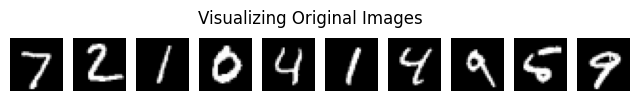

Visualizing reconstructions for fold 1


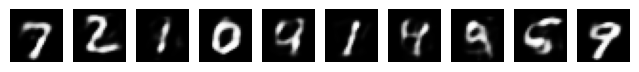

Visualizing reconstructions for fold 2


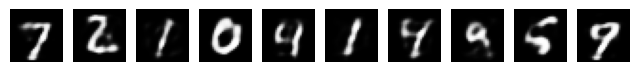

Visualizing reconstructions for fold 3


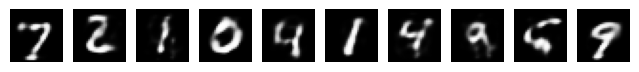

Visualizing reconstructions for fold 4


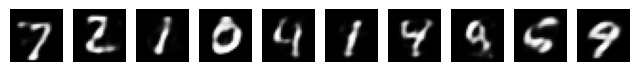

Visualizing reconstructions for fold 5


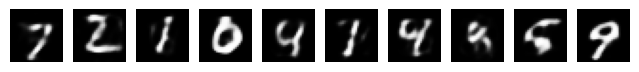

Visualizing reconstructions for fold 6


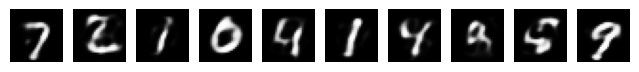

Visualizing reconstructions for fold 7


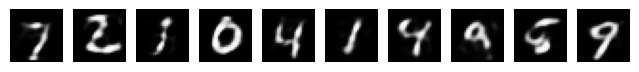

Visualizing reconstructions for fold 8


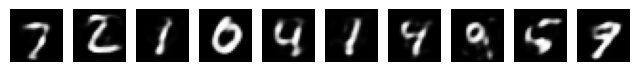

Visualizing reconstructions for fold 9


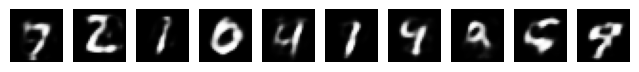

Visualizing reconstructions for fold 10


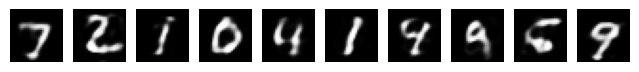

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_4.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_4 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_4):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

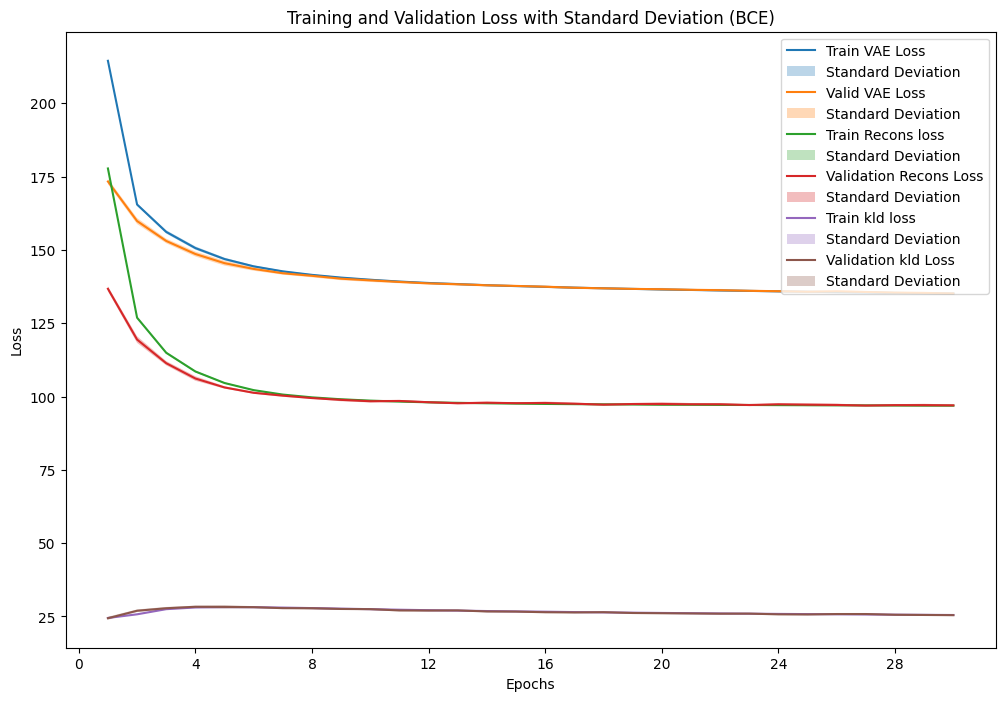

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_4 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_4_1 = VAE_plot_results(fold_results_5_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_4_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_4_1['epochs'])
    VAE_plot_mean_std(result_data_5_4_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_4_1['epochs'])
    VAE_plot_mean_std(result_data_5_4_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_4_1['epochs'])
    VAE_plot_mean_std(result_data_5_4_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_4_1['epochs'])
    VAE_plot_mean_std(result_data_5_4_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_4_1['epochs'])
    VAE_plot_mean_std(result_data_5_4_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_4_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_4_1['valid_metrics'],
    result_data_5_4_1['test_metrics'],
    result_data_5_4_1['valid_result'],
    result_data_5_4_1['test_result'],
    result_data_5_4_1['recons_valid_result'],
    result_data_5_4_1['recons_test_result'],
    result_data_5_4_1['kld_valid_result'],
    result_data_5_4_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.123767           0.122045           135.185012     133.862397               97.033443         97.033443            25.434380      25.452716
Standard Deviation                 0.000340           0.000237             0.333875       0.093387                0.266676          0.266676             0.188214       0.156690

Detailed Evaluation Table:


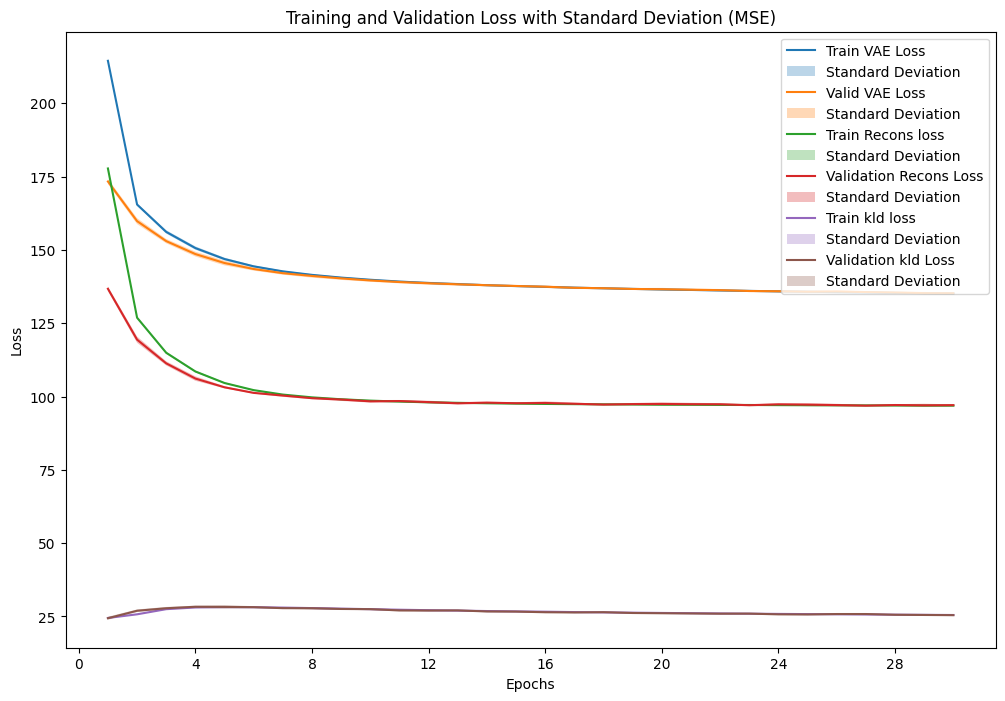

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_4 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_4_2 = VAE_plot_results(fold_results_5_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_4_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_4_2['epochs'])
    VAE_plot_mean_std(result_data_5_4_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_4_2['epochs'])
    VAE_plot_mean_std(result_data_5_4_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_4_2['epochs'])
    VAE_plot_mean_std(result_data_5_4_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_4_2['epochs'])
    VAE_plot_mean_std(result_data_5_4_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_4_2['epochs'])
    VAE_plot_mean_std(result_data_5_4_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_4_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_4_2['valid_metrics'],
    result_data_5_4_2['test_metrics'],
    result_data_5_4_2['valid_result'],
    result_data_5_4_2['test_result'],
    result_data_5_4_2['recons_valid_result'],
    result_data_5_4_2['recons_test_result'],
    result_data_5_4_2['kld_valid_result'],
    result_data_5_4_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.019835           0.019342           135.173802     133.827073               97.022233         97.022233            25.434380      25.452716
Standard Deviation                 0.000063           0.000082             0.359310       0.140380                0.231062          0.231062             0.188214       0.156690

Detailed Evaluation Table:


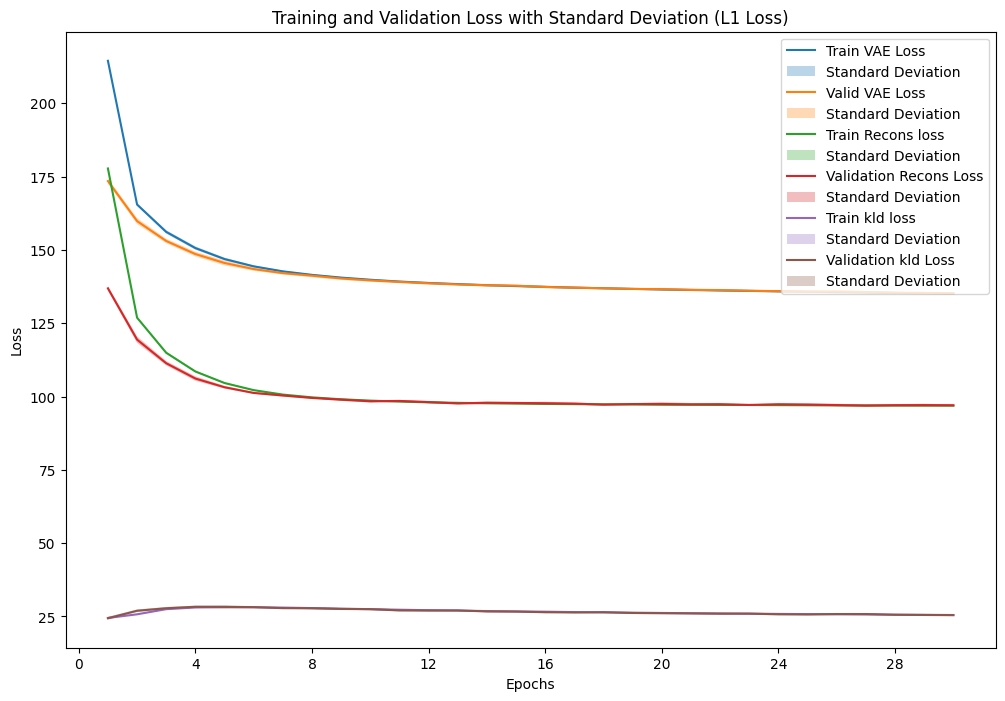

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_4.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_4 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_4_3 = VAE_plot_results(fold_results_5_4, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_4_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_4_3['epochs'])
    VAE_plot_mean_std(result_data_5_4_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_4_3['epochs'])
    VAE_plot_mean_std(result_data_5_4_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_4_3['epochs'])
    VAE_plot_mean_std(result_data_5_4_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_4_3['epochs'])
    VAE_plot_mean_std(result_data_5_4_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_4_3['epochs'])
    VAE_plot_mean_std(result_data_5_4_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_4_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_4_3['valid_metrics'],
    result_data_5_4_3['test_metrics'],
    result_data_5_4_3['valid_result'],
    result_data_5_4_3['test_result'],
    result_data_5_4_3['recons_valid_result'],
    result_data_5_4_3['recons_test_result'],
    result_data_5_4_3['kld_valid_result'],
    result_data_5_4_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.055063           0.054235           135.185528     133.874034               97.033959         97.033959            25.434380      25.452716
Standard Deviation                 0.000189           0.000231             0.335578       0.133421                0.281918          0.281918             0.188214       0.156690

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_4 = sum(p.numel() for p in models_5_4[0].parameters())
print(f"Number of parameters in the model: {total_params_5_4}")

Number of parameters in the model: 151440


### Sample new data using the decoder.

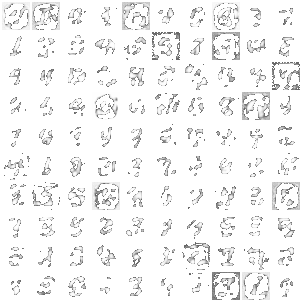

In [ ]:
sample(models_5_4[8],D_z=64)

## Test 2 VAE: BCE

### Experiments 2 : VAE with $\beta$ =0.02 with n_layer =2

- We evaluate the performance of both the autoencoder and the variational autoencoder by systematically varying the latent space dimensionality (Dz) across different values, specifically {2, 16, 32}. Additionally, for this assessment, we set the number of layers (n_layer) to be equal to 1, considering likelihoods modeled as Bernoulli.

### Experiment 3.1 : VAE with 2 layer

- Model: VAE of 2 layer, D_x=784, D_z=2, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_6 = 'VAE'
model_config_5_6 = {'D_x': 784, 'n_layers': 2, 'D_z': 2, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_6, fold_results_5_6 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_6),
                                                model_config=model_config_5_6,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:184.636119, Training Recons Loss: 178.247073, Training KLD Loss: 4.259364
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.04962852846910345, 'L1 Loss': 0.11445129060364784, 'BCE': 0.20844598320570398}, Validation VAE Loss: {'MSE': 170.0189243073159, 'L1 Loss': 169.89805992613447, 'BCE': 169.95980753797167}, Validation Recons Loss: {'MSE': 163.48076824431723, 'L1 Loss': 163.35990402546335, 'BCE': 163.42165147497298}, Validation KLD Loss: {'MSE': 4.358770834638717, 'L1 Loss': 4.358770834638717, 'BCE': 4.358770834638717}
Train Fold/Epoch: 1/2, Training Loss:167.413303, Training Recons Loss: 160.739929, Training KLD Loss: 4.448917
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.047711871921065005, 'L1 Loss': 0.11022801958817116, 'BCE': 0.2025220717521424}, Validation VAE Loss: {'MSE': 16

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_6.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_6.pkl')

In [ ]:
# Save models_3_6
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_6, f)

# Save fold_results_3_6
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_6, f)


## Visualizing reconstructions for all fold

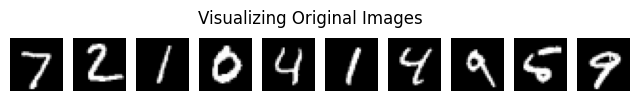

Visualizing reconstructions for fold 1


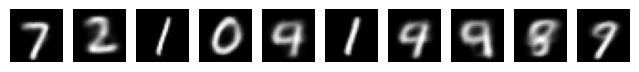

Visualizing reconstructions for fold 2


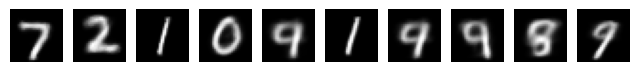

Visualizing reconstructions for fold 3


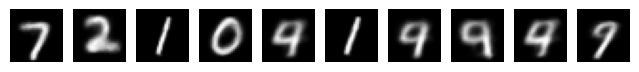

Visualizing reconstructions for fold 4


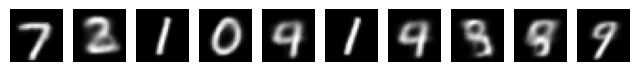

Visualizing reconstructions for fold 5


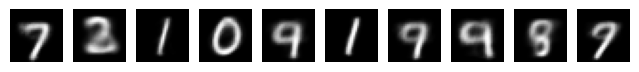

Visualizing reconstructions for fold 6


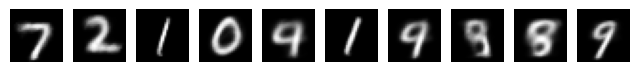

Visualizing reconstructions for fold 7


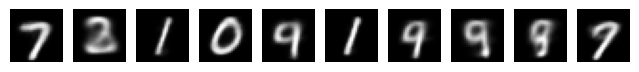

Visualizing reconstructions for fold 8


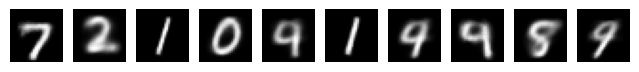

Visualizing reconstructions for fold 9


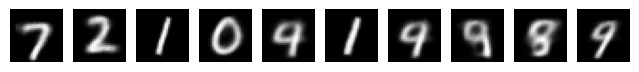

Visualizing reconstructions for fold 10


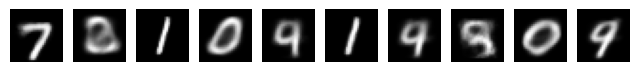

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_6.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_6 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_6):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

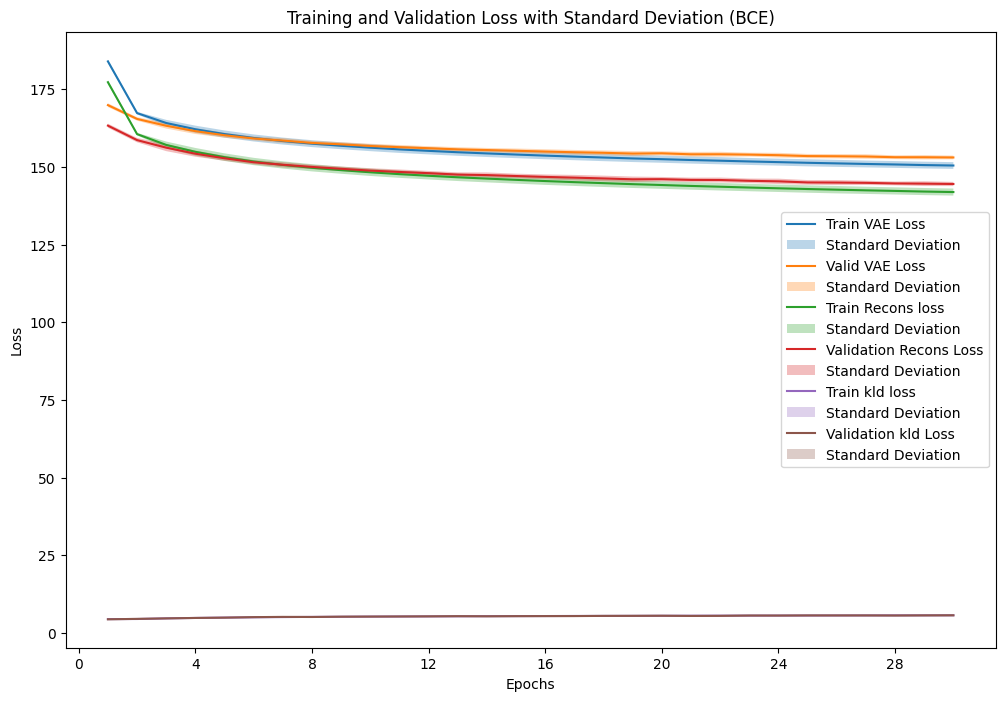

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_6 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_6_1 = VAE_plot_results(fold_results_5_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_6_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_6_1['epochs'])
    VAE_plot_mean_std(result_data_5_6_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_6_1['epochs'])
    VAE_plot_mean_std(result_data_5_6_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_6_1['epochs'])
    VAE_plot_mean_std(result_data_5_6_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_6_1['epochs'])
    VAE_plot_mean_std(result_data_5_6_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_6_1['epochs'])
    VAE_plot_mean_std(result_data_5_6_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_6_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_6_1['valid_metrics'],
    result_data_5_6_1['test_metrics'],
    result_data_5_6_1['valid_result'],
    result_data_5_6_1['test_result'],
    result_data_5_6_1['recons_valid_result'],
    result_data_5_6_1['recons_test_result'],
    result_data_5_6_1['kld_valid_result'],
    result_data_5_6_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.184369           0.184072           153.084498     152.807902              144.545515        144.545515             5.692655       5.663470
Standard Deviation                 0.000894           0.001574             0.628776       1.153845                0.700933          0.700933             0.134524       0.130629

Detailed Evaluation Table:


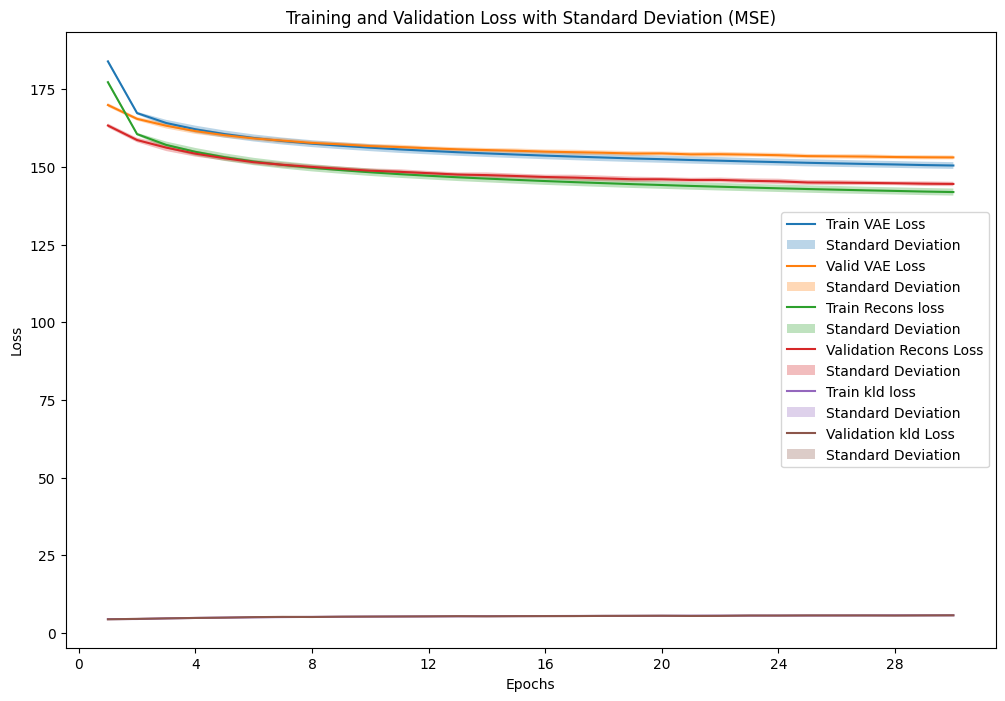

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_6 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_6_2 = VAE_plot_results(fold_results_5_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_6_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_6_2['epochs'])
    VAE_plot_mean_std(result_data_5_6_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_6_2['epochs'])
    VAE_plot_mean_std(result_data_5_6_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_6_2['epochs'])
    VAE_plot_mean_std(result_data_5_6_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_6_2['epochs'])
    VAE_plot_mean_std(result_data_5_6_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_6_2['epochs'])
    VAE_plot_mean_std(result_data_5_6_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_6_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_6_2['valid_metrics'],
    result_data_5_6_2['test_metrics'],
    result_data_5_6_2['valid_result'],
    result_data_5_6_2['test_result'],
    result_data_5_6_2['recons_valid_result'],
    result_data_5_6_2['recons_test_result'],
    result_data_5_6_2['kld_valid_result'],
    result_data_5_6_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.041410           0.041401           153.084683     152.828921              144.545700        144.545700             5.692655       5.663470
Standard Deviation                 0.000412           0.000590             0.612612       1.134996                0.692052          0.692052             0.134524       0.130629

Detailed Evaluation Table:


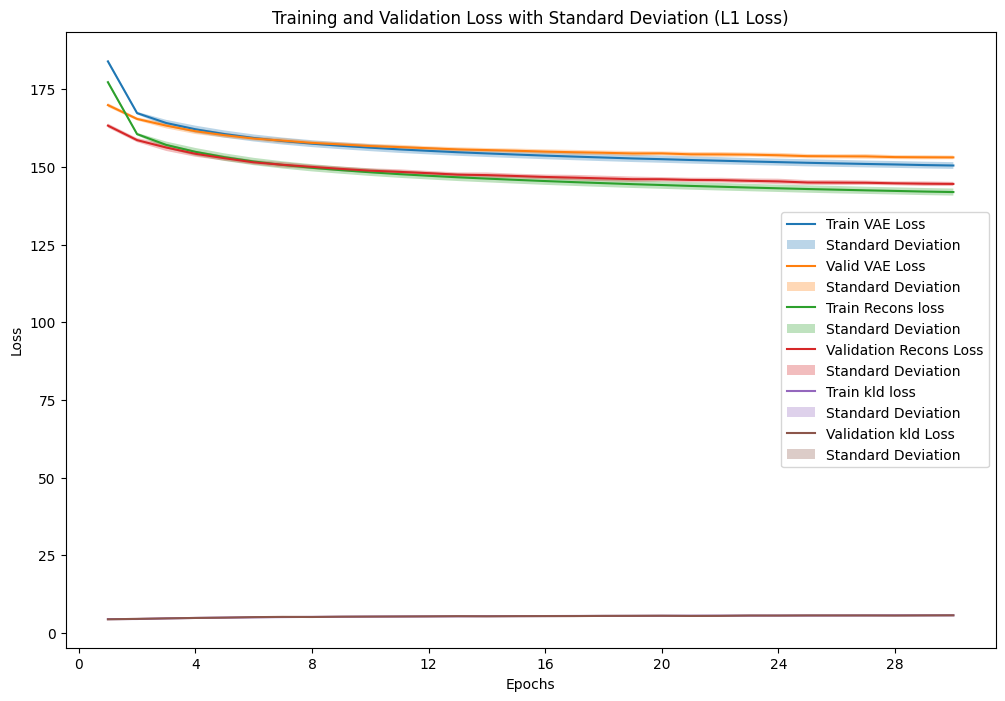

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_6.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_6 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_6_3 = VAE_plot_results(fold_results_5_6, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_6_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_6_3['epochs'])
    VAE_plot_mean_std(result_data_5_6_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_6_3['epochs'])
    VAE_plot_mean_std(result_data_5_6_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_6_3['epochs'])
    VAE_plot_mean_std(result_data_5_6_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_6_3['epochs'])
    VAE_plot_mean_std(result_data_5_6_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_6_3['epochs'])
    VAE_plot_mean_std(result_data_5_6_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_6_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_6_3['valid_metrics'],
    result_data_5_6_3['test_metrics'],
    result_data_5_6_3['valid_result'],
    result_data_5_6_3['test_result'],
    result_data_5_6_3['recons_valid_result'],
    result_data_5_6_3['recons_test_result'],
    result_data_5_6_3['kld_valid_result'],
    result_data_5_6_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.097185           0.097355           153.088694     152.832375              144.549711        144.549711             5.692655       5.663470
Standard Deviation                 0.000827           0.001153             0.588194       1.152519                0.664971          0.664971             0.134524       0.130629

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_6 = sum(p.numel() for p in models_5_6[0].parameters())
print(f"Number of parameters in the model: {total_params_5_6}")

Number of parameters in the model: 620156


<ipython-input-9-14e9441719e3>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(np.unique(labels)))


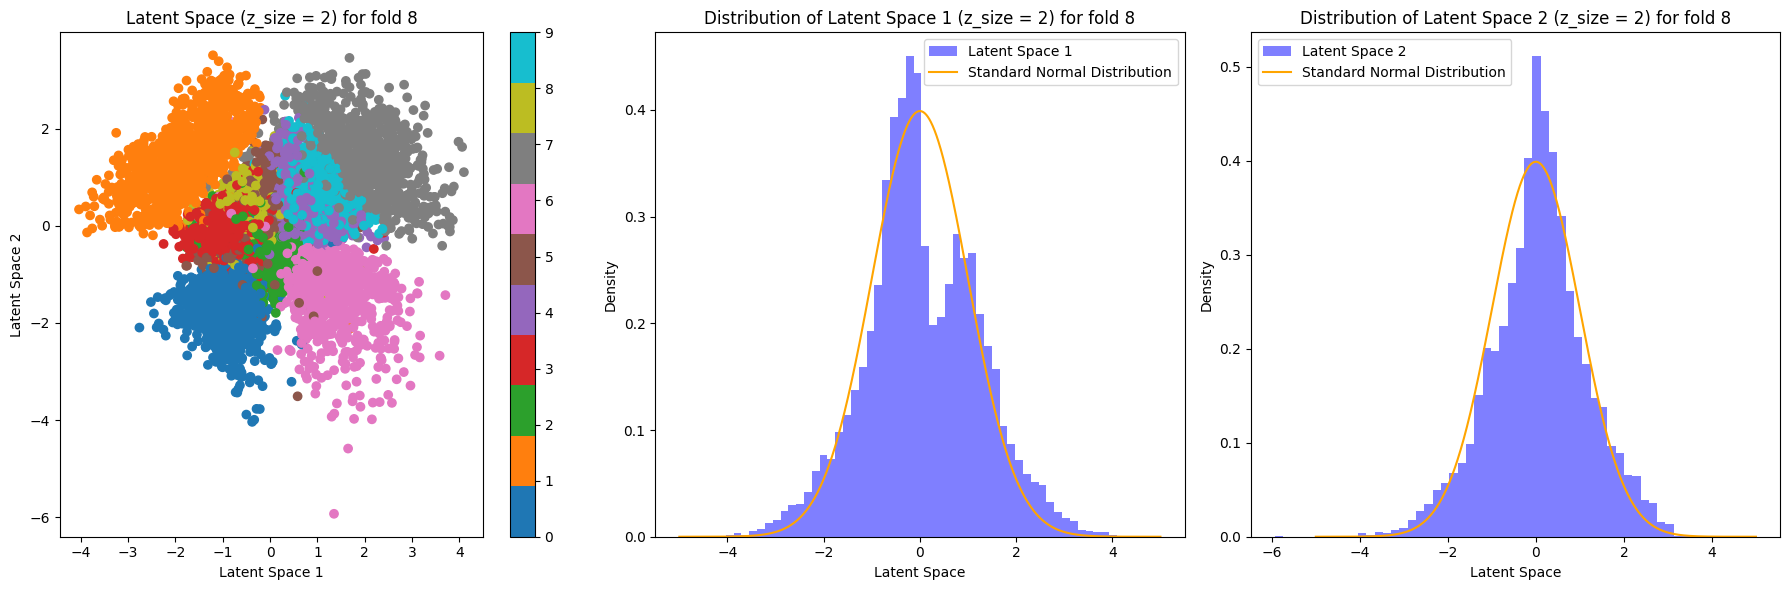

In [ ]:
latent_space_VAE_model(models_5_6[7], test_loader, device, number_fold=8)

### Sample new data using the decoder.

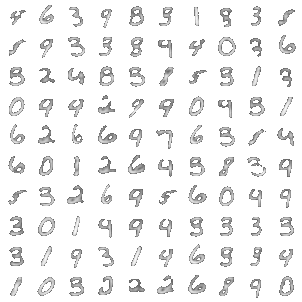

In [ ]:
sample(models_5_6[7],D_z=2)

### Examine the influence of different values of the latent vector z on the results.


We can look at how different values in the latent vector z influence the results.

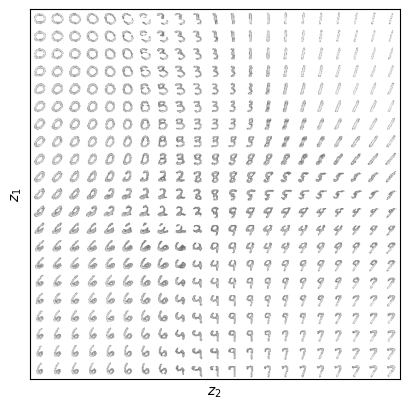

In [ ]:
VAE_visualize_latent_space(models_5_6[7], device)

### Experiment 3.2 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=16, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_7 = 'VAE'
model_config_5_7 = {'D_x': 784, 'n_layers': 2, 'D_z': 16, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_7, fold_results_5_7 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_7),
                                                model_config=model_config_5_7,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:156.977733, Training Recons Loss: 137.280076, Training KLD Loss: 13.131771
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.024252271299508025, 'L1 Loss': 0.06490366842518462, 'BCE': 0.13612465132424173}, Validation VAE Loss: {'MSE': 131.42701980915476, 'L1 Loss': 131.56182065923164, 'BCE': 131.41297539244306}, Validation Recons Loss: {'MSE': 106.73577134152676, 'L1 Loss': 106.87057129880215, 'BCE': 106.72172643783244}, Validation KLD Loss: {'MSE': 16.460832605970666, 'L1 Loss': 16.460832605970666, 'BCE': 16.460832605970666}
Train Fold/Epoch: 1/2, Training Loss:127.496791, Training Recons Loss: 101.005152, Training KLD Loss: 17.661093
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.020705689676105976, 'L1 Loss': 0.056003359086970066, 'BCE': 0.12512209900516144}, Validation VAE Loss: {

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_7.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_7.pkl')

In [ ]:
# Save models_3_7
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_7, f)

# Save fold_results_3_7
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_7, f)


## Visualizing reconstructions for all fold

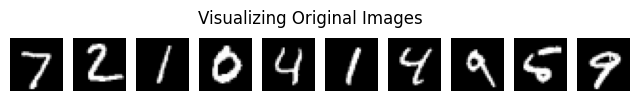

Visualizing reconstructions for fold 1


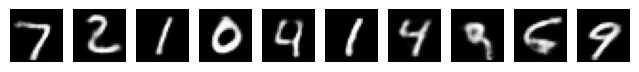

Visualizing reconstructions for fold 2


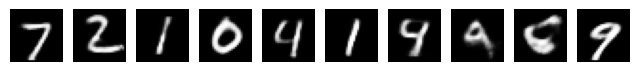

Visualizing reconstructions for fold 3


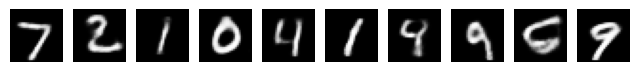

Visualizing reconstructions for fold 4


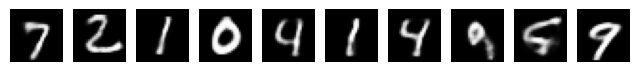

Visualizing reconstructions for fold 5


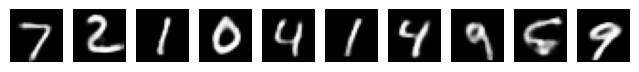

Visualizing reconstructions for fold 6


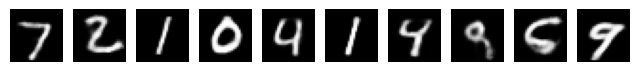

Visualizing reconstructions for fold 7


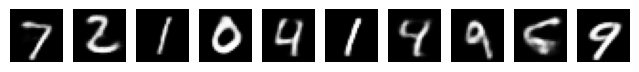

Visualizing reconstructions for fold 8


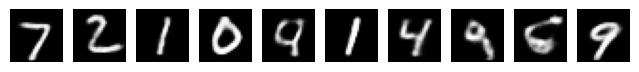

Visualizing reconstructions for fold 9


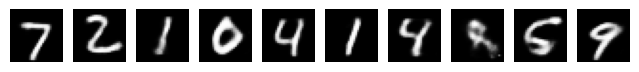

Visualizing reconstructions for fold 10


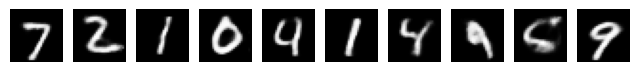

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_7.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_7 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_7):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

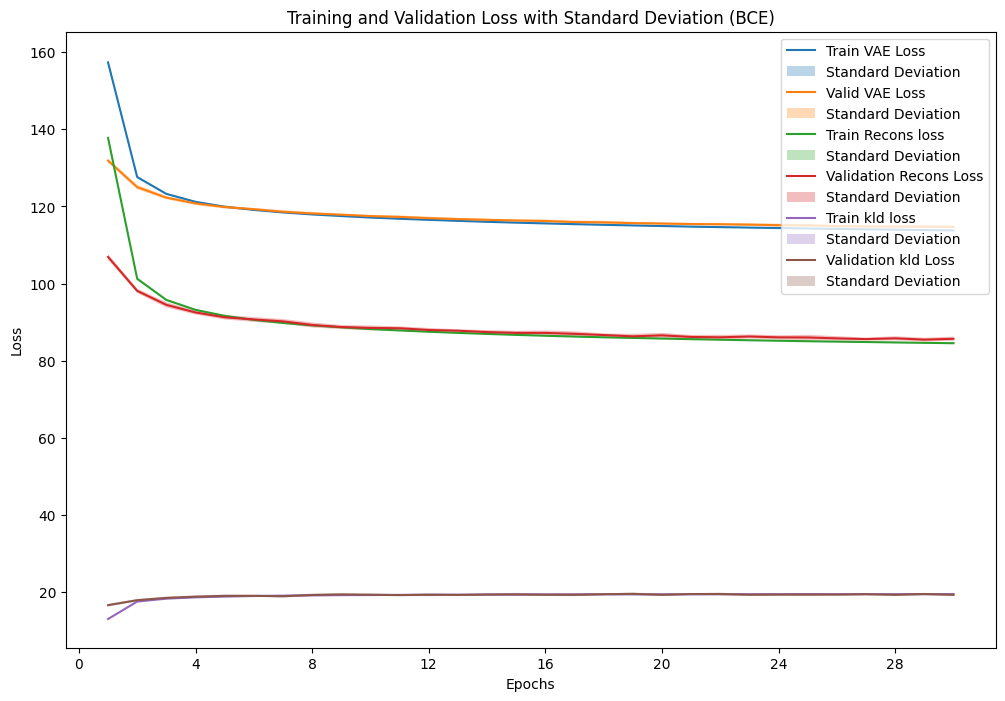

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_7 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_7_1 = VAE_plot_results(fold_results_5_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_7_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_7_1['epochs'])
    VAE_plot_mean_std(result_data_5_7_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_7_1['epochs'])
    VAE_plot_mean_std(result_data_5_7_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_7_1['epochs'])
    VAE_plot_mean_std(result_data_5_7_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_7_1['epochs'])
    VAE_plot_mean_std(result_data_5_7_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_7_1['epochs'])
    VAE_plot_mean_std(result_data_5_7_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_7_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_7_1['valid_metrics'],
    result_data_5_7_1['test_metrics'],
    result_data_5_7_1['valid_result'],
    result_data_5_7_1['test_result'],
    result_data_5_7_1['recons_valid_result'],
    result_data_5_7_1['recons_test_result'],
    result_data_5_7_1['kld_valid_result'],
    result_data_5_7_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.109289           0.108124           114.681462     113.763206               85.682948         85.682948            19.332343      19.329399
Standard Deviation                 0.000725           0.000682             0.314288       0.151903                0.568539          0.568539             0.370488       0.359944

Detailed Evaluation Table:


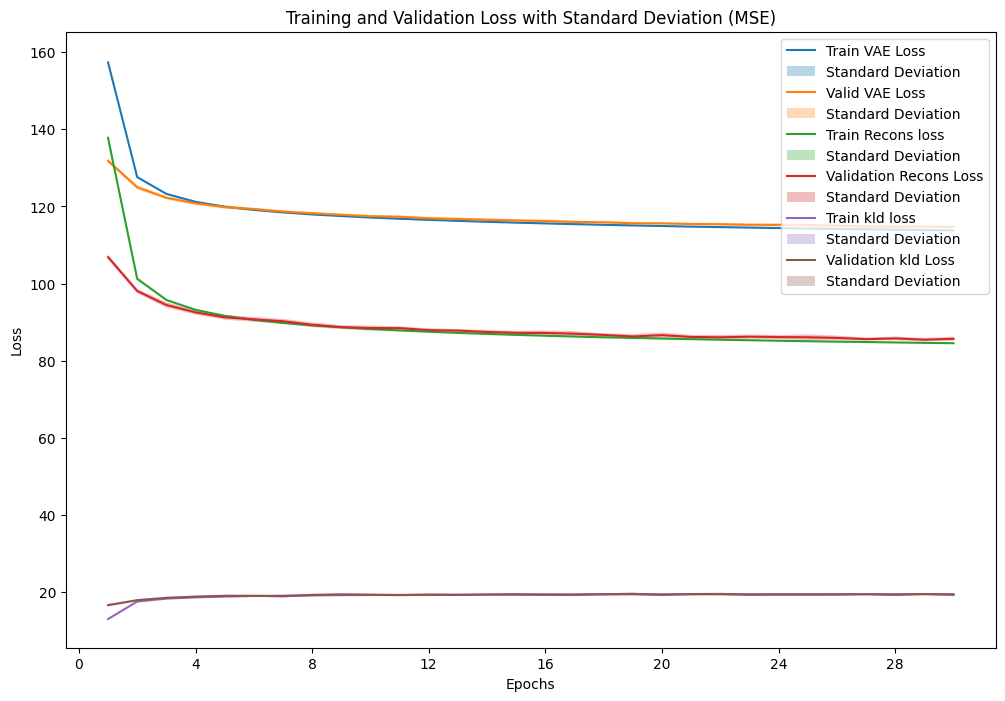

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_7 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_7_2 = VAE_plot_results(fold_results_5_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_7_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_7_2['epochs'])
    VAE_plot_mean_std(result_data_5_7_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_7_2['epochs'])
    VAE_plot_mean_std(result_data_5_7_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_7_2['epochs'])
    VAE_plot_mean_std(result_data_5_7_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_7_2['epochs'])
    VAE_plot_mean_std(result_data_5_7_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_7_2['epochs'])
    VAE_plot_mean_std(result_data_5_7_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_7_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_7_2['valid_metrics'],
    result_data_5_7_2['test_metrics'],
    result_data_5_7_2['valid_result'],
    result_data_5_7_2['test_result'],
    result_data_5_7_2['recons_valid_result'],
    result_data_5_7_2['recons_test_result'],
    result_data_5_7_2['kld_valid_result'],
    result_data_5_7_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.015619           0.015318           114.700766     113.787964               85.702252         85.702252            19.332343      19.329399
Standard Deviation                 0.000238           0.000241             0.257065       0.115719                0.551910          0.551910             0.370488       0.359944

Detailed Evaluation Table:


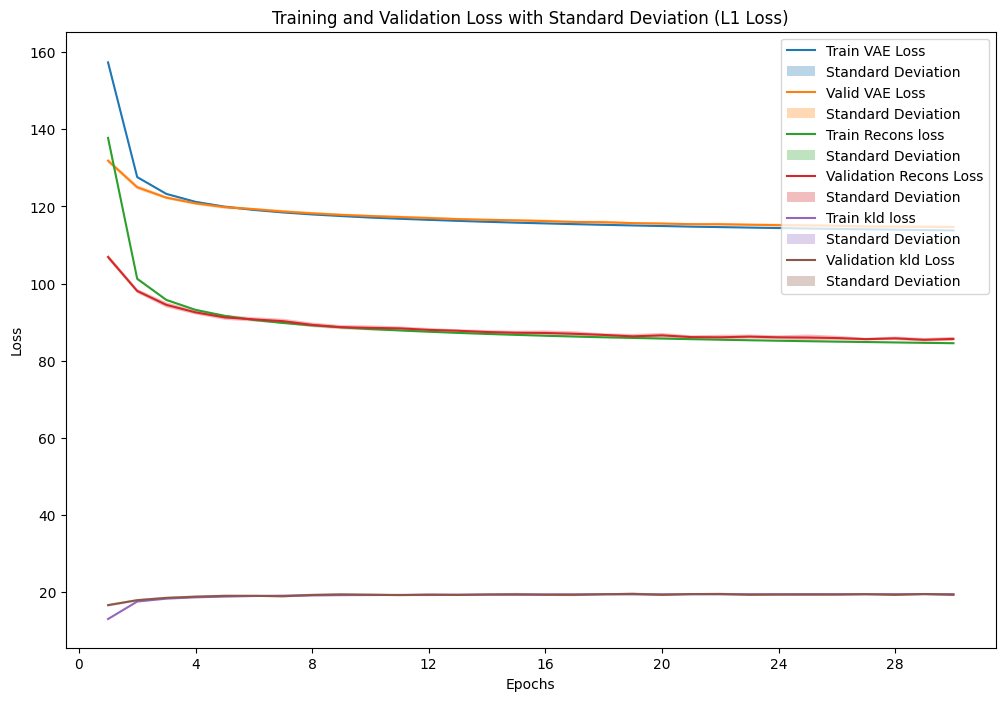

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_7.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_7 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_7_3 = VAE_plot_results(fold_results_5_7, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_7_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_7_3['epochs'])
    VAE_plot_mean_std(result_data_5_7_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_7_3['epochs'])
    VAE_plot_mean_std(result_data_5_7_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_7_3['epochs'])
    VAE_plot_mean_std(result_data_5_7_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_7_3['epochs'])
    VAE_plot_mean_std(result_data_5_7_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_7_3['epochs'])
    VAE_plot_mean_std(result_data_5_7_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_7_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_7_3['valid_metrics'],
    result_data_5_7_3['test_metrics'],
    result_data_5_7_3['valid_result'],
    result_data_5_7_3['test_result'],
    result_data_5_7_3['recons_valid_result'],
    result_data_5_7_3['recons_test_result'],
    result_data_5_7_3['kld_valid_result'],
    result_data_5_7_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.045645           0.045025           114.702118     113.791333               85.703604         85.703604            19.332343      19.329399
Standard Deviation                 0.000450           0.000414             0.276088       0.105707                0.548952          0.548952             0.370488       0.359944

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_7 = sum(p.numel() for p in models_5_7[0].parameters())
print(f"Number of parameters in the model: {total_params_5_7}")

Number of parameters in the model: 648016


### Sample new data using the decoder.

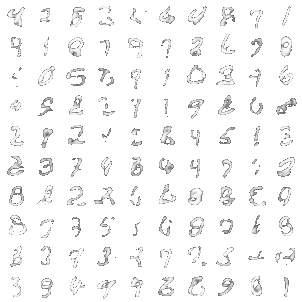

In [ ]:
sample(models_5_7[9],D_z=16)

### Experiment 3.3 : VAE with $\beta$ =0.02 with n_layer=2

- Model: VAE of 2 layer, D_x=784, D_z=32, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_8 = 'VAE'
model_config_5_8 = {'D_x': 784, 'n_layers': 2, 'D_z': 32, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_8, fold_results_5_8 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_8),
                                                model_config=model_config_5_8,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:161.042468, Training Recons Loss: 140.935453, Training KLD Loss: 13.404677
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.025910595927308214, 'L1 Loss': 0.06783947316890067, 'BCE': 0.1409388872537207}, Validation VAE Loss: {'MSE': 136.10048058692445, 'L1 Loss': 135.98273500483086, 'BCE': 135.98935171898376}, Validation Recons Loss: {'MSE': 110.6072160436752, 'L1 Loss': 110.48947029925407, 'BCE': 110.4960877438809}, Validation KLD Loss: {'MSE': 16.9955098375361, 'L1 Loss': 16.9955098375361, 'BCE': 16.9955098375361}
Train Fold/Epoch: 1/2, Training Loss:130.429642, Training Recons Loss: 102.956780, Training KLD Loss: 18.315241
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.021222484714173255, 'L1 Loss': 0.057868013396225076, 'BCE': 0.12670847765625792}, Validation VAE Loss: {'MSE': 12

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_8.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_8.pkl')

In [ ]:
# Save models_3_8
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_8, f)

# Save fold_results_3_8
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_8, f)


## Visualizing reconstructions for all fold

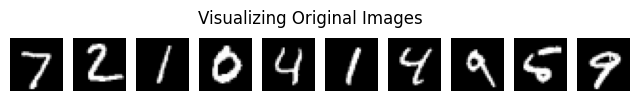

Visualizing reconstructions for fold 1


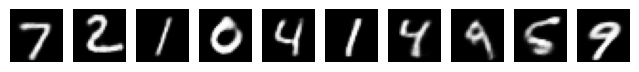

Visualizing reconstructions for fold 2


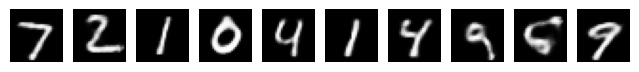

Visualizing reconstructions for fold 3


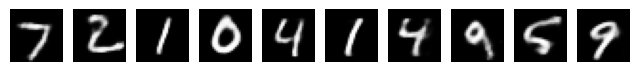

Visualizing reconstructions for fold 4


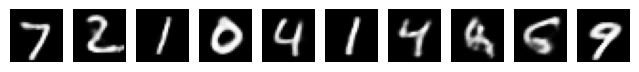

Visualizing reconstructions for fold 5


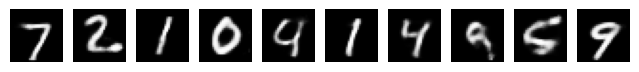

Visualizing reconstructions for fold 6


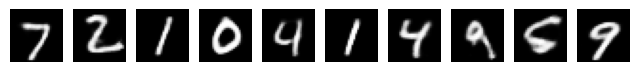

Visualizing reconstructions for fold 7


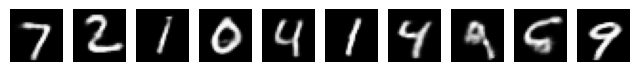

Visualizing reconstructions for fold 8


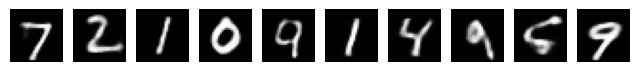

Visualizing reconstructions for fold 9


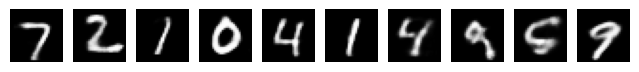

Visualizing reconstructions for fold 10


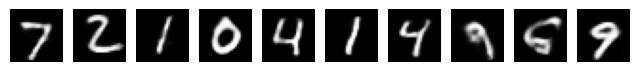

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_8.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_8 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_8):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

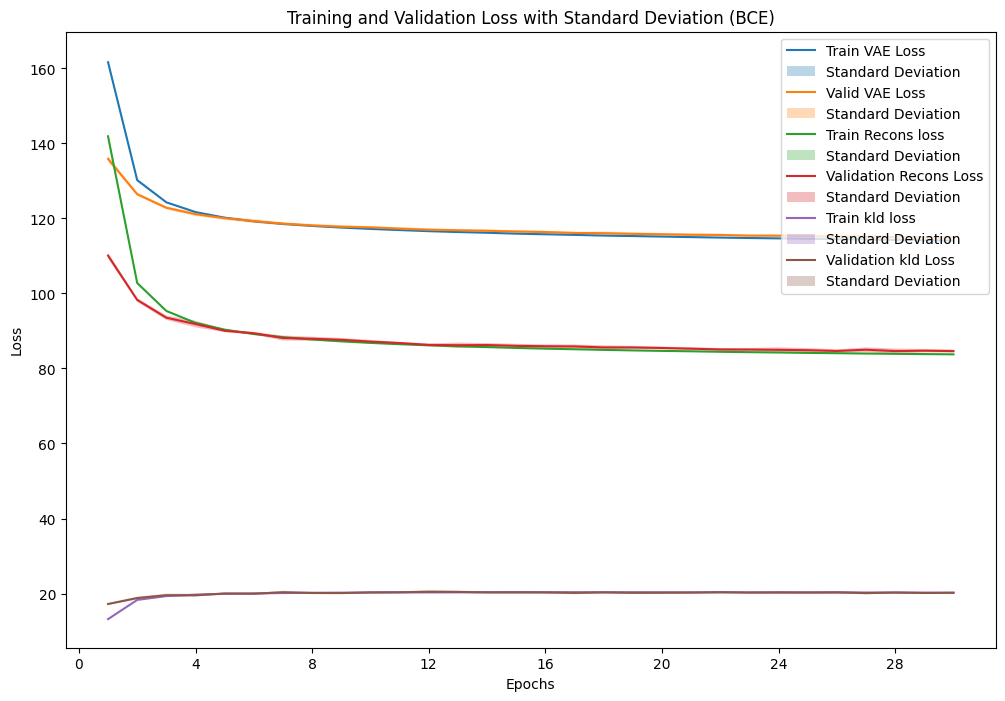

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_8 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_8_1 = VAE_plot_results(fold_results_5_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_8_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_8_1['epochs'])
    VAE_plot_mean_std(result_data_5_8_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_8_1['epochs'])
    VAE_plot_mean_std(result_data_5_8_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_8_1['epochs'])
    VAE_plot_mean_std(result_data_5_8_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_8_1['epochs'])
    VAE_plot_mean_std(result_data_5_8_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_8_1['epochs'])
    VAE_plot_mean_std(result_data_5_8_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_8_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_8_1['valid_metrics'],
    result_data_5_8_1['test_metrics'],
    result_data_5_8_1['valid_result'],
    result_data_5_8_1['test_result'],
    result_data_5_8_1['recons_valid_result'],
    result_data_5_8_1['recons_test_result'],
    result_data_5_8_1['kld_valid_result'],
    result_data_5_8_1['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.107957           0.106797           114.932356     113.980451               84.638506         84.638506             20.19590      20.167495
Standard Deviation                 0.000525           0.000337             0.409397       0.143291                0.411658          0.411658              0.16025       0.152666

Detailed Evaluation Table:


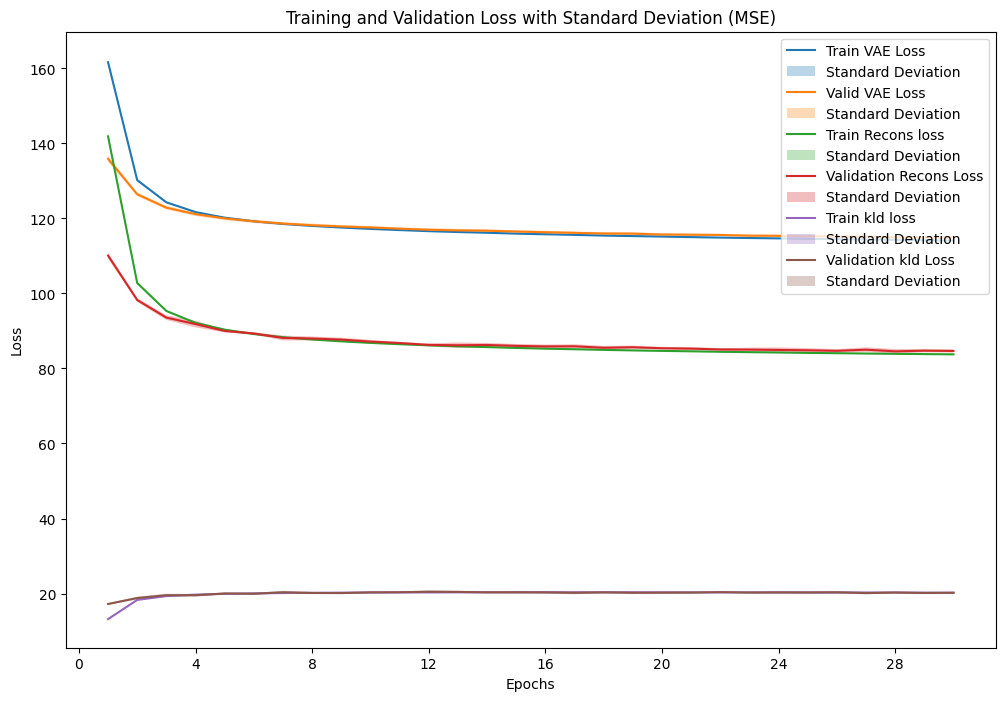

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_8 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_8_2 = VAE_plot_results(fold_results_5_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_8_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_8_2['epochs'])
    VAE_plot_mean_std(result_data_5_8_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_8_2['epochs'])
    VAE_plot_mean_std(result_data_5_8_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_8_2['epochs'])
    VAE_plot_mean_std(result_data_5_8_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_8_2['epochs'])
    VAE_plot_mean_std(result_data_5_8_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_8_2['epochs'])
    VAE_plot_mean_std(result_data_5_8_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_8_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_8_2['valid_metrics'],
    result_data_5_8_2['test_metrics'],
    result_data_5_8_2['valid_result'],
    result_data_5_8_2['test_result'],
    result_data_5_8_2['recons_valid_result'],
    result_data_5_8_2['recons_test_result'],
    result_data_5_8_2['kld_valid_result'],
    result_data_5_8_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.015177           0.014884           114.917997     113.986434               84.624146         84.624146             20.19590      20.167495
Standard Deviation                 0.000119           0.000112             0.394471       0.156201                0.376045          0.376045              0.16025       0.152666

Detailed Evaluation Table:


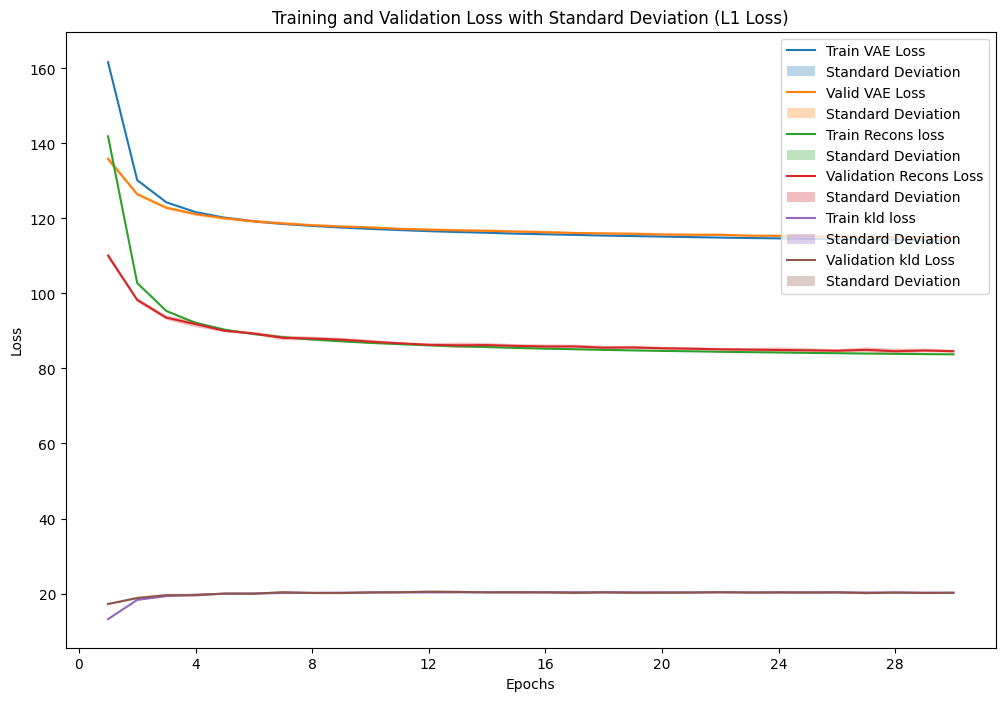

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_8.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_8 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_8_3 = VAE_plot_results(fold_results_5_8, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_8_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_8_3['epochs'])
    VAE_plot_mean_std(result_data_5_8_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_8_3['epochs'])
    VAE_plot_mean_std(result_data_5_8_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_8_3['epochs'])
    VAE_plot_mean_std(result_data_5_8_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_8_3['epochs'])
    VAE_plot_mean_std(result_data_5_8_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_8_3['epochs'])
    VAE_plot_mean_std(result_data_5_8_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_8_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_8_3['valid_metrics'],
    result_data_5_8_3['test_metrics'],
    result_data_5_8_3['valid_result'],
    result_data_5_8_3['test_result'],
    result_data_5_8_3['recons_valid_result'],
    result_data_5_8_3['recons_test_result'],
    result_data_5_8_3['kld_valid_result'],
    result_data_5_8_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.044853           0.044268           114.917329     114.028502               84.623479         84.623479             20.19590      20.167495
Standard Deviation                 0.000264           0.000262             0.411150       0.159424                0.405383          0.405383              0.16025       0.152666

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_8 = sum(p.numel() for p in models_5_8[0].parameters())
print(f"Number of parameters in the model: {total_params_5_8}")

Number of parameters in the model: 680576


### Sample new data using the decoder.

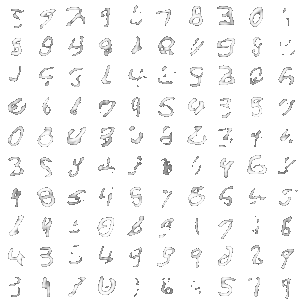

In [ ]:
sample(models_5_8[9],D_z=32)

### Experiment 2.4 : VAE with 2 layer

- Model: VAE of 1 layer, D_x=784, D_z=64, activation is RELU
- Loss: Bernoulli likelihood
- Training with ADAM, LR=1e-3, for 30 epochs

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAE_model_name_5_9 = 'VAE'
model_config_5_9 = {'D_x': 784, 'n_layers': 2, 'D_z': 64, 'activation': nn.ReLU}
learning_rate = 1e-3
batch_size=64
training_setup = {
    # Adam optimizer with given learning rate
    # 'optimizer' : torch.optim.Adam(
    #     AE_model_1.parameters(), # Model parameters
    #     learning_rate #LR
    #   ),
    'epochs' : 30,
    'criterion' : VAE_criterion,
    'device' : device,
    'VAE_likelihood' : 'bernoulli'
}
# Define a dataset
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
models_5_9, fold_results_5_9 = VAE_k_fold_cross_validation(
                                                model_class=getattr(sys.modules[__name__], VAE_model_name_5_9),
                                                model_config=model_config_5_9,
                                                train_dataset =train_dataset,
                                                test_dataset = test_dataset,
                                                VAE_criterion= VAE_criterion,
                                                learning_rate=learning_rate,
                                                training_setup= training_setup,
                                                beta=1.5,
                                                L=1,
                                                k_folds=10,
                                                batch_size=batch_size,
                                                eval_criterions={
                                                'MSE': torch.nn.MSELoss(),
                                                'L1 Loss': torch.nn.L1Loss(),
                                                'BCE': torch.nn.BCELoss()
                                                      })

Fold 1/10
54000
6000
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()
Train Fold/Epoch: 1/1, Training Loss:165.565731, Training Recons Loss: 146.187300, Training KLD Loss: 12.918954
Validation Fold/Epoch: 1/1,  Validation Loss: {'MSE': 0.028104519075218666, 'L1 Loss': 0.07252961452654068, 'BCE': 0.14745983639930157}, Validation VAE Loss: {'MSE': 140.84154981247923, 'L1 Loss': 140.92157209680437, 'BCE': 140.6601340111266}, Validation Recons Loss: {'MSE': 115.78992689416764, 'L1 Loss': 115.86995015245803, 'BCE': 115.60851190445271}, Validation KLD Loss: {'MSE': 16.7010816107405, 'L1 Loss': 16.7010816107405, 'BCE': 16.7010816107405}
Train Fold/Epoch: 1/2, Training Loss:133.358458, Training Recons Loss: 106.771330, Training KLD Loss: 17.724752
Validation Fold/Epoch: 1/2,  Validation Loss: {'MSE': 0.021863462601570374, 'L1 Loss': 0.05933947128025775, 'BCE': 0.12864436787810732}, Validation VAE Loss: {'MSE': 1

### Create the directory and save it in My Drive

In [ ]:
# Define the directory path
directory = '/content/drive/MyDrive/Master Thesis/Study the impact of $\\beta$/Beta=1.5/experience_1_3/'

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)
# Define file paths
models_file_path = os.path.join(directory, 'models_5_9.pkl')
fold_results_file_path = os.path.join(directory, 'fold_results_5_9.pkl')

In [ ]:
# Save models_3_1
with open(models_file_path, 'wb') as f:
    pickle.dump(models_5_9, f)

# Save fold_results_3_1
with open(fold_results_file_path, 'wb') as f:
    pickle.dump(fold_results_5_9, f)


## Visualizing reconstructions for all fold

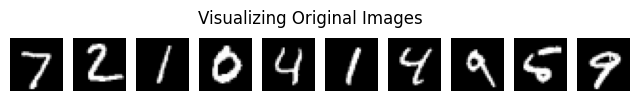

Visualizing reconstructions for fold 1


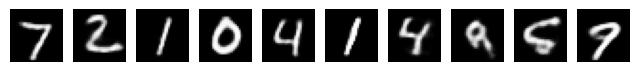

Visualizing reconstructions for fold 2


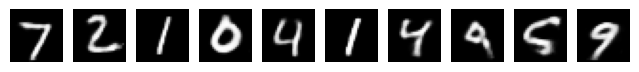

Visualizing reconstructions for fold 3


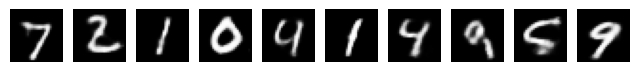

Visualizing reconstructions for fold 4


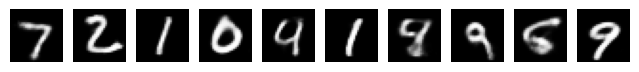

Visualizing reconstructions for fold 5


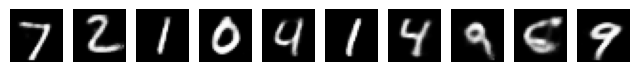

Visualizing reconstructions for fold 6


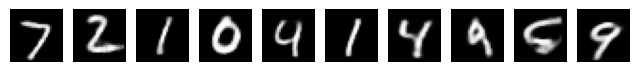

Visualizing reconstructions for fold 7


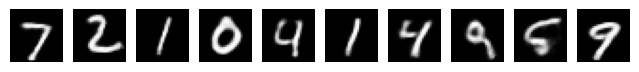

Visualizing reconstructions for fold 8


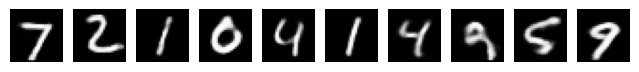

Visualizing reconstructions for fold 9


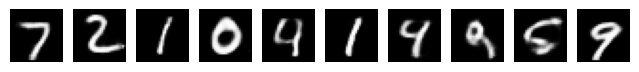

Visualizing reconstructions for fold 10


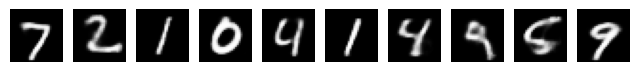

In [ ]:
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'models_5_9.pkl')

# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        models_5_9 = pickle.load(f)

    # Iterate over the loaded models
    VAE_visualize_original_images(test_loader, img_shape=(28, 28))
    for fold_index, model_to_visualize in enumerate(models_5_9):
        print(f"Visualizing reconstructions for fold {fold_index + 1}")
        VAE_visualize_reconstructions(model_to_visualize, test_loader, img_shape, L=1, device=device, num_samples=10, fold_index=fold_index + 1, figure_size=(8, 2))

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)

### Plot Training Loss and Validation Loss functions with Standard Deviation

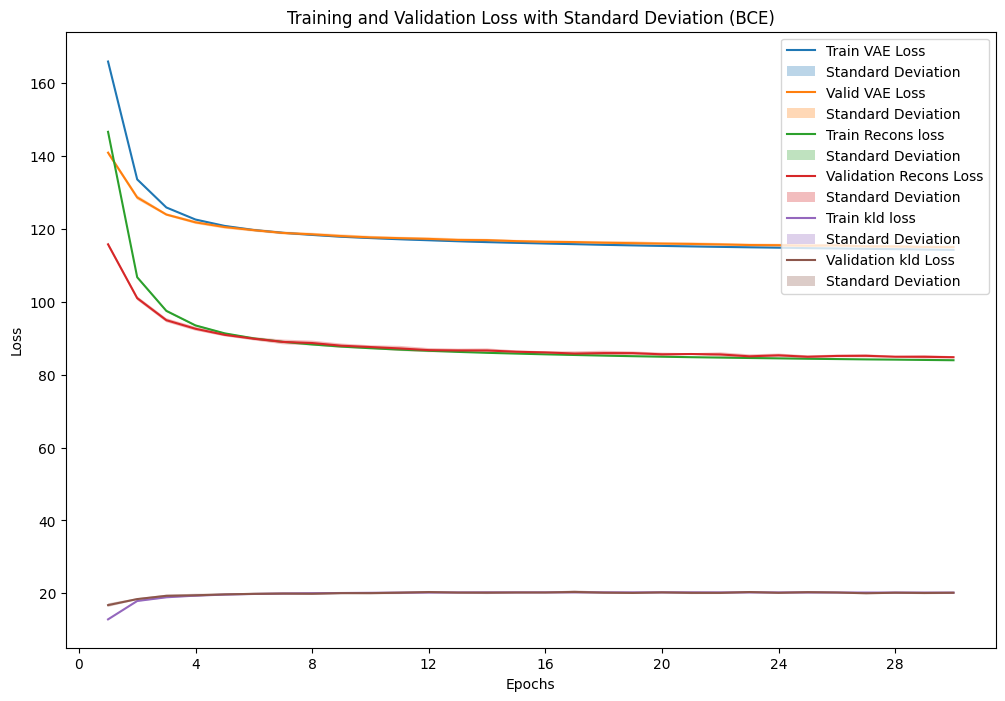

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_9 = pickle.load(f)

    loss_type_to_plot = 'BCE'   # We can change this to our desired loss type
    result_data_5_9_1 = VAE_plot_results(fold_results_5_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_9_1['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_9_1['epochs'])
    VAE_plot_mean_std(result_data_5_9_1['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_9_1['epochs'])
    VAE_plot_mean_std(result_data_5_9_1['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_9_1['epochs'])
    VAE_plot_mean_std(result_data_5_9_1['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_9_1['epochs'])
    VAE_plot_mean_std(result_data_5_9_1['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_9_1['epochs'])
    VAE_plot_mean_std(result_data_5_9_1['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_9_1['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_9_1['valid_metrics'],
    result_data_5_9_1['test_metrics'],
    result_data_5_9_1['valid_result'],
    result_data_5_9_1['test_result'],
    result_data_5_9_1['recons_valid_result'],
    result_data_5_9_1['recons_test_result'],
    result_data_5_9_1['kld_valid_result'],
    result_data_5_9_1['kld_test_result']
)


Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.108131           0.107013           115.014298     114.122116               84.774407         84.774407            20.159927      20.149238
Standard Deviation                 0.000427           0.000481             0.332943       0.119557                0.334417          0.334417             0.308903       0.272722

Detailed Evaluation Table:


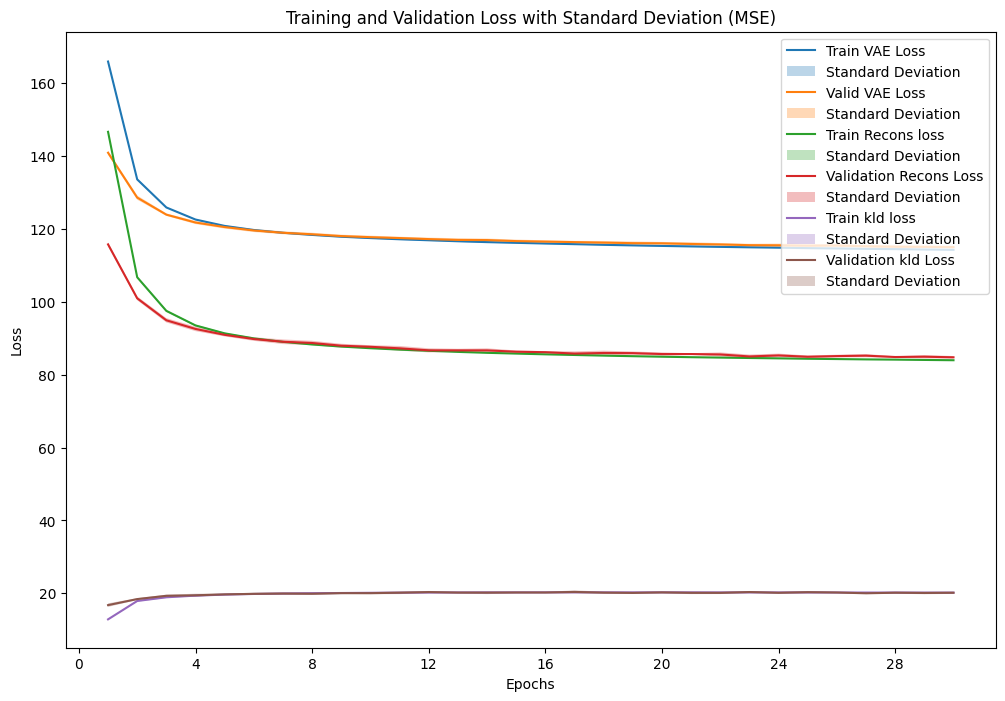

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_9 = pickle.load(f)

    loss_type_to_plot = 'MSE'   # We can change this to our desired loss type
    result_data_5_9_2 = VAE_plot_results(fold_results_5_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_9_2['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_9_2['epochs'])
    VAE_plot_mean_std(result_data_5_9_2['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_9_2['epochs'])
    VAE_plot_mean_std(result_data_5_9_2['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_9_2['epochs'])
    VAE_plot_mean_std(result_data_5_9_2['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_9_2['epochs'])
    VAE_plot_mean_std(result_data_5_9_2['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_9_2['epochs'])
    VAE_plot_mean_std(result_data_5_9_2['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_9_2['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_9_2['valid_metrics'],
    result_data_5_9_2['test_metrics'],
    result_data_5_9_2['valid_result'],
    result_data_5_9_2['test_result'],
    result_data_5_9_2['recons_valid_result'],
    result_data_5_9_2['recons_test_result'],
    result_data_5_9_2['kld_valid_result'],
    result_data_5_9_2['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.015251           0.014948           115.018111     114.116063               84.778220         84.778220            20.159927      20.149238
Standard Deviation                 0.000164           0.000160             0.357558       0.142300                0.368482          0.368482             0.308903       0.272722

Detailed Evaluation Table:


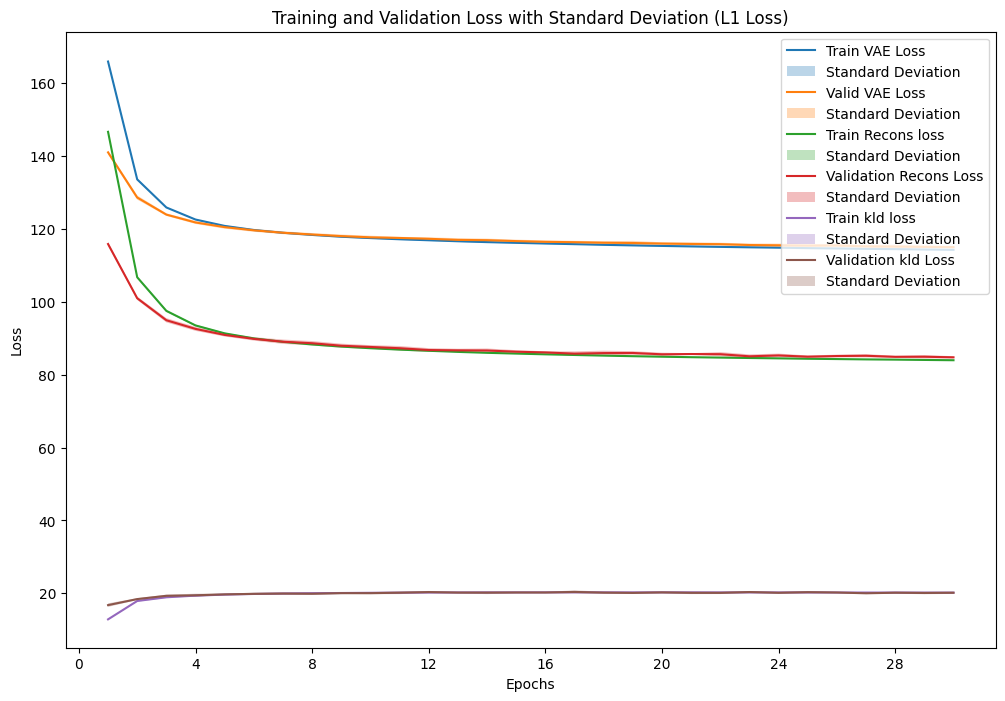

In [ ]:
# Define the directory and file path using raw string literals
directory = r'/content/drive/MyDrive/Master Thesis/Study the impact of $\beta$/Beta=1.5/experience_1_3/'
file_path = os.path.join(directory, 'fold_results_5_9.pkl')
# Load the models from the pickle file
try:
    with open(file_path, 'rb') as f:
        fold_results_5_9 = pickle.load(f)

    loss_type_to_plot = 'L1 Loss'   # We can change this to our desired loss type
    result_data_5_9_3 = VAE_plot_results(fold_results_5_9, loss_type_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))
    VAE_plot_mean_std(result_data_5_9_3['train_losses'], 'Training and Validation Loss', ax, 'Train VAE Loss', result_data_5_9_3['epochs'])
    VAE_plot_mean_std(result_data_5_9_3['val_losses'], 'Training and Validation Loss', ax, 'Valid VAE Loss', result_data_5_9_3['epochs'])
    VAE_plot_mean_std(result_data_5_9_3['train_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Train Recons loss', result_data_5_9_3['epochs'])
    VAE_plot_mean_std(result_data_5_9_3['val_recons_losses'], 'Training and Validation Recontruction Loss', ax, 'Validation Recons Loss', result_data_5_9_3['epochs'])
    VAE_plot_mean_std(result_data_5_9_3['train_kld_losses'], 'Training and Validation KLD Loss', ax, 'Train kld loss', result_data_5_9_3['epochs'])
    VAE_plot_mean_std(result_data_5_9_3['val_kld_losses'], 'Training and Validation KLD Loss', ax, 'Validation kld Loss', result_data_5_9_3['epochs'])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(f'Training and Validation Loss with Standard Deviation ({loss_type_to_plot})')
    ax.legend()
    plt.show()

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print("An error occurred:", e)


In [ ]:
print_evaluation_table(
    result_data_5_9_3['valid_metrics'],
    result_data_5_9_3['test_metrics'],
    result_data_5_9_3['valid_result'],
    result_data_5_9_3['test_result'],
    result_data_5_9_3['recons_valid_result'],
    result_data_5_9_3['recons_test_result'],
    result_data_5_9_3['kld_valid_result'],
    result_data_5_9_3['kld_test_result']
)



Mean and Standard Deviation Table:
            Metric  Validation Metrics Loss  Test Metrics Loss  Validation VAE Loss  Test VAE Loss  Validation Recons Loss  Test Recons Loss  Validation KLD Loss  Test KLD Loss
              Mean                 0.044862           0.044257           114.986930     114.109964               84.747039         84.747039            20.159927      20.149238
Standard Deviation                 0.000266           0.000348             0.399619       0.134180                0.321594          0.321594             0.308903       0.272722

Detailed Evaluation Table:


### Number of parameters

In [ ]:
# Count the number of parameters
total_params_5_9 = sum(p.numel() for p in models_5_9[0].parameters())
print(f"Number of parameters in the model: {total_params_5_9}")

Number of parameters in the model: 748000


### Sample new data using the decoder.

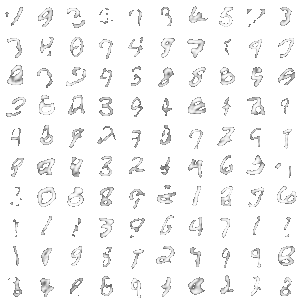

In [ ]:
sample(models_5_9[8],D_z=64)

# Table

In [ ]:
def create_dataframe(result_data, total_params_list, n_layer, dz_values):
    models_count = len(result_data)

    models = [''] * models_count
    vae_validation = [''] * models_count
    vae_testing = [''] * models_count
    total_params_per_model = [''] * models_count

    for i in range(models_count):
        mean_valid_metrics_loss = np.mean(result_data[i]['valid_metrics'])
        std_valid_metrics_loss = np.std(result_data[i]['valid_metrics'])
        mean_test_metrics_loss = np.mean(result_data[i]['test_metrics'])
        std_test_metrics_loss = np.std(result_data[i]['test_metrics'])

        models[i] = f"$D_x$: 784, $n_{{layers}}$: {n_layer[i]}, $D_z$: {dz_values[i]}"
        vae_validation[i] = f"{mean_valid_metrics_loss:.6f} ± {std_valid_metrics_loss:.6f}"
        vae_testing[i] = f"{mean_test_metrics_loss:.6f} ± {std_test_metrics_loss:.6f}"
        total_params_per_model[i] = total_params_list[i] if i < len(total_params_list) else ''

    data = pd.DataFrame({
        'Models': models,
        'VAE Validation': vae_validation,
        'VAE Testing': vae_testing,
        'Number of Parameters': total_params_per_model
    })

    return data

result_data = [
    result_data_5_1_1, result_data_5_1_2, result_data_5_1_3,
    result_data_5_2_1, result_data_5_2_2, result_data_5_2_3,
    result_data_5_3_1, result_data_5_3_2, result_data_5_3_3,
    result_data_5_4_1, result_data_5_4_2, result_data_5_4_3,
    result_data_5_6_1, result_data_5_6_2, result_data_5_6_3,
    result_data_5_7_1, result_data_5_7_2, result_data_5_7_3,
    result_data_5_8_1, result_data_5_8_2, result_data_5_8_3,
    result_data_5_9_1, result_data_5_9_2, result_data_5_9_3
]
total_params = ['', total_params_5_1, '',
                '', total_params_5_2, '',
                '', total_params_5_3, '',
                '', total_params_5_4, '',
                '', total_params_5_6,'',
                '', total_params_5_7,'',
                '', total_params_5_8,'',
                '', total_params_5_9,'']
n_layer = [1] * 12 + [2] * 12  # 12 models with n_layers = 1 and 12 models with n_layers = 2
dz_values = [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3 + [2] * 3 + [16] * 3 + [32] * 3 + [64] * 3 # 12 models with D_z = 1 and 12 models with D_z = 2
#dz_values = [1] * 12 + [2] * 12  # 12 models with D_z = 1 and 12 models with D_z = 2
data = create_dataframe(result_data, total_params, n_layer, dz_values)

# Convert dataframe to LaTeX and add \hline after each first row and after the first three rows
latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")
latex_output = "\\begin{table}\n\\begin{center}\n" + latex_output + "\\caption{Training VAE with BCE table.}\n\\label{tab:table1}\n\\end{center}\n\\end{table}"
latex_output = latex_output.replace('\\toprule', '\\toprule\n\\hline', 1)  # add after first row
latex_output = latex_output.replace('\\end{tabular}', '\\hline\n\\end{tabular}', -1)  # add \hline at the end
print(latex_output)


\begin{table}
\begin{center}
\begin{tabular}{|c|c|c|c|}
\toprule
\hline
                                Models &      VAE Validation &         VAE Testing & Number of Parameters \\
\midrule
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.228052 ± 0.000902 & 0.226930 ± 0.000231 &                      \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.056202 ± 0.000271 & 0.055972 ± 0.000083 &                 5492 \\
 $D_x$: 784, $n_{layers}$: 1, $D_z$: 2 & 0.127275 ± 0.000496 & 0.127098 ± 0.000498 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.144052 ± 0.000532 & 0.142173 ± 0.000421 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.026644 ± 0.000139 & 0.026095 ± 0.000136 &                38448 \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 16 & 0.068995 ± 0.000316 & 0.068086 ± 0.000331 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.125470 ± 0.000489 & 0.123643 ± 0.000402 &                      \\
$D_x$: 784, $n_{layers}$: 1, $D_z$: 32 & 0.0203

<ipython-input-108-590761742cfe>:53: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = data.to_latex(index=False, escape=False, column_format="|c|c|c|c|")


$$\textbf{METRIC} : BCE$$

$$
\begin{array}{c|S|r}
{\textbf{Model}}{\textbf{}} & \textbf{ $β =0.02$-VAE Validadion} & \textbf{$β =0.02$-Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1$-VAE Validation} & \textbf{$β =1$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =1.5$-VAE Validation} & \textbf{$β =1.5$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{$β =10$-VAE Validation} & \textbf{$β =10$-VAE Testing} & \textbf{Observation (overfitting)} & \textbf{VAE Number of Parameters} \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 2 & 0.226275 \pm 0.001036 & 0.225166 \pm 0.000662 & No & 0.227426 \pm 0.000807 & 0.226353 \pm 0.000118 & No &  0.228052 \pm  0.000902 & 0.226930 \pm 0.000231 & No & 0.239047 \pm 0.001129 & 0.238689 \pm 0.000748  & No & 5492\\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 16 & 0.127615 \pm  0.000348 & 0.125684 \pm 0.000077 & No & 0.138684 \pm 0.000436 & 0.136730 \pm 0.000278 & No & 0.144070 \pm 0.000446 & 0.142173 \pm 0.000265 & No &  0.138747 \pm 0.000398 & 0.136760 \pm 0.000257 & No & 38448 \\
\hline \\
D_x: 784, n_{layers}: 1, D_z: 32 & 0.093204 \pm 0.000321 & 0.091596 \pm 0.000083 & No &  0.114784 \pm 0.000397 & 0.113037 \pm 0.000186 & No & 0.125249 \pm 0.000701& 0.123467 \pm 0.000630  & No & 0.221198 \pm 0.000950 & 0.220252 \pm 0.000617 & No & 76112\\
\hline \\
\textbf{D_x: 784, n_{layers}: 1, D_z: 64} & \textbf{ 0.073867} \pm \textbf{0.000287} & \textbf{0.072968} \pm \textbf{0.000105} & No & \textbf{0.109525} \pm \textbf{0.000464} & \textbf{0.108042} \pm \textbf{0.000376} & No & \textbf{0.123874} \pm \textbf{0.000349} & \textbf{0.122243} \pm \textbf{0.000522} & \textbf{No} & \textbf{0.221015} \pm \textbf{0.000921} & \textbf{0.220111} \pm 0.000803 & \textbf{No} & \textbf{151440}\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 2 & 0.181346 \pm  0.001216 &  0.181094 \pm 0.000885 & Yes &  0.184722 \pm 0.001426 & 0.184430 \pm 0.001378 & Yes & 0.185251 \pm  0.001356  & 0.185076 \pm 0.001369 & Yes & 0.204847 \pm 0.001291 & 0.204616 \pm 0.001091  & No & 620156\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 16 & 0.088940 \pm 0.000316 & 0.087978 \pm 0.000131 & Yes &  0.102318 \pm  0.000711 & 0.101194 \pm 0.000515 & Yes & 0.109030 \pm 0.000502 & 0.107935 \pm 0.000414 & Yes & 0.185056 \pm 0.000977 & 0.184375\pm 0.000760  & No & 648016\\
\hline \\
D_x: 784, n_{layers}: 2, D_z: 32 & 0.075699 \pm 0.000266 & 0.074949 \pm 0.000093 & Yes & 0.098988 \pm 0.000679 & 0.097934 \pm 0.000546 & Yes &  0.107636 \pm 0.000740 & 0.106483 \pm 0.000663 & Yes & 0.185831 \pm 0.001297 &  0.185198 \pm 0.000978  & No & 680576\\
\hline \\
\color{red}{D_x: 784, n_{layers}: 2, D_z: 64} & \color{red}{0.069187\pm 0.000225} & \color{red}{0.068637 \pm 0.000056 } & \color{red}{Yes} & \color{red}{ 0.099061 \pm 0.000934} & \color{red}{0.098014 \pm 0.000880} & \color{red}{Yes} & \color{red}{0.107992 \pm 0.000326} & \color{red}{0.106826 \pm 0.000498} & \color{red}{Yes} & 0.188006 \pm 0.000799 & 0.187317 \pm  0.001166 & \color{red}{No} & \color{red}{748000} \\
\hline
\end{array}
$$